# Training with new ntuple

# prepare

## 1 - Load modules

In [1]:
import sys
sys.path.append("..") # add self-defined module in the parent path
sys.path.append("../..") # add self-defined module in the parent path
import time

from array import array
import datetime
import keras.backend
from keras.models import Sequential, Model, load_model
from keras.layers import Concatenate, Dense, Input
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adagrad, SGD, RMSprop, Adam
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn import preprocessing
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from lfv_pdnn_code_v1.train import model
from lfv_pdnn_code_v1.train.train_utils import *
from lfv_pdnn_code_v1.common.common_utils import *

Using TensorFlow backend.


## 2 - Load new array
### a) load background samples

In [2]:
# Set parent path to access data
data_path = "/mnt/e/data/new_ntuple/mc16a"

# Load
print "Loading new background array."
# di_boson
directory = data_path + "/di_boson"
search_pattern = "*.npy"
absolute_file_list, file_name_list = get_file_list(directory, search_pattern)
xb_di_boson = np.array([])
for path in absolute_file_list:
    temp_array = np.load(path)
    if len(temp_array) == 0:
        continue
    if len(xb_di_boson) == 0:
        xb_di_boson = temp_array.copy()
    else:
        xb_di_boson = np.concatenate((xb_di_boson, temp_array))
print "xb_di_boson shape:", xb_di_boson.shape
# top_quark
directory = data_path + "/top_quark"
search_pattern = "*.npy"
absolute_file_list, file_name_list = get_file_list(directory, search_pattern)
xb_top_quark = np.array([])
for path in absolute_file_list:
    temp_array = np.load(path)
    if len(temp_array) == 0:
        continue
    if len(xb_top_quark) == 0:
        xb_top_quark = temp_array.copy()
    else:
        xb_top_quark = np.concatenate((xb_top_quark, temp_array))
print "xb_top_quark shape:", xb_top_quark.shape
# w_jets
directory = data_path + "/w_jets"
search_pattern = "*.npy"
absolute_file_list, file_name_list = get_file_list(directory, search_pattern)
xb_w_jets = np.array([])
for path in absolute_file_list:
    temp_array = np.load(path)
    if len(temp_array) == 0:
        continue
    if len(xb_w_jets) == 0:
        xb_w_jets = temp_array.copy()
    else:
        xb_w_jets = np.concatenate((xb_w_jets, temp_array))
print "xb_w_jets shape:", xb_w_jets.shape
# z_ll
directory = data_path + "/z_ll"
search_pattern = "*.npy"
absolute_file_list, file_name_list = get_file_list(directory, search_pattern)
xb_z_ll = np.array([])
for path in absolute_file_list:
    temp_array = np.load(path)
    if len(temp_array) == 0:
        continue
    if len(xb_z_ll) == 0:
        xb_z_ll = temp_array.copy()
    else:
        xb_z_ll = np.concatenate((xb_z_ll, temp_array))
print "xb_z_ll shape:", xb_z_ll.shape

# Add all background together
print "\nAdding all background together."
xb = np.concatenate((xb_di_boson, xb_top_quark, xb_w_jets, xb_z_ll))
print "xb shape:", xb.shape

# Organize with dict
print "\nOrganizing new background with dict: xb_dict_new."
xb_dict_new = {}
xb_dict_new['di_boson'] = xb_di_boson
xb_dict_new['top_quark'] = xb_top_quark
xb_dict_new['w_jets'] = xb_w_jets
xb_dict_new['z_ll'] = xb_z_ll
xb_dict_new['all'] = xb

print "\nDone."

Loading new background array.
xb_di_boson shape: (69860, 24)
xb_top_quark shape: (68355, 24)
xb_w_jets shape: (2575, 24)
xb_z_ll shape: (407, 24)

Adding all background together.
xb shape: (141197, 24)

Organizing new background with dict: xb_dict_new.

Done.


### b) load signal samples
when all up different signal mass point together, two method applied:
* xs: directly add each mass point signal together
* xs_norm: each mass point sample is normalized before add together/


In [3]:
# Initialize
mass_min = 5000
mass_max = 0
xs_studied = np.array([])
mass_scan_map = [500, 2000]
#mass_scan_map = [500]
xs_dict_new = {}

# Load
print "Loading new signal array."
print "\nOrganizing new signal with dict: xs_dict_new."
data_path = "/mnt/e/data/new_ntuple/mc16a"
xs = np.array([])
xs_norm = np.array([])
for i, mass in enumerate(mass_scan_map):
    # load signal
    xs_add = np.load(data_path + "/signal/rpv_emu_{}GeV.npy".format(mass))
    xs_temp = np.load(data_path + "/signal/rpv_etau_{}GeV.npy".format(mass))
    xs_add = np.concatenate((xs_add, xs_temp))
    xs_temp = np.load(data_path + "/signal/rpv_mutau_{}GeV.npy".format(mass))
    xs_add = np.concatenate((xs_add, xs_temp))
    # add to dict xs_dict_new
    print "adding {}GeV signal to xs_dict_new".format(mass), xs_add.shape
    xs_dict_new['{}GeV'.format(mass)] = xs_add
    # add to full signals
    if len(xs) == 0:
        xs = xs_add.copy()
        xs_add_norm = modify_array(xs_add, weight_id = -1, norm = True)
        xs_norm = xs_add_norm.copy()
    else:
        xs = np.concatenate((xs, xs_add))
        xs_add_norm = modify_array(xs_add, weight_id = -1, norm = True)
        xs_norm = np.concatenate((xs_norm, xs_add_norm))
print "adding all signal to xs_dict_new"
xs_dict_new['all'] = xs
print "adding all_norm signal to xs_dict_new"
xs_dict_new['all_norm'] = xs_norm

print "\nDone."

Loading new signal array.

Organizing new signal with dict: xs_dict_new.
adding 500GeV signal to xs_dict_new (5087, 24)
adding 2000GeV signal to xs_dict_new (6293, 24)
adding all signal to xs_dict_new
adding all_norm signal to xs_dict_new

Done.


## 2 - Load old array
### a) load old background samples

In [4]:
# Load
print "Loading new background array."
xb_di_boson_old = np.load('/mnt/e/data/lfv/ntuples_last_run/TestData/data_npy/tree_bkg1.npy')
xb_drell_yan_old = np.load('/mnt/e/data/lfv/ntuples_last_run/TestData/data_npy/tree_bkg2.npy')
xb_top_quark_old = np.load('/mnt/e/data/lfv/ntuples_last_run/TestData/data_npy/tree_bkg3.npy')
xb_w_jets_old = np.load('/mnt/e/data/lfv/ntuples_last_run/TestData/data_npy/tree_bkg4.npy')
xb_z_ll_old = np.load('/mnt/e/data/lfv/ntuples_last_run/TestData/data_npy/tree_bkg5.npy')
xb_old = np.concatenate((xb_di_boson_old, xb_drell_yan_old, xb_top_quark_old, xb_w_jets_old, xb_z_ll_old))

# Organize with dict
print "\nOrganizing new background with dict: xb_dict_old."
xb_dict_old = {}
xb_dict_old['di_boson'] = xb_di_boson_old
xb_dict_old['drell_yan'] = xb_drell_yan_old
xb_dict_old['top_quark'] = xb_top_quark_old
xb_dict_old['w_jets'] = xb_w_jets_old
xb_dict_old['z_ll'] = xb_z_ll_old
xb_dict_old['all'] = xb_old

print "\nDone."

Loading new background array.

Organizing new background with dict: xb_dict_old.

Done.


### b) load old signal samples

In [5]:
# Initialize
mass_min = 5000
mass_max = 0
xs_old = np.array([])
xs_old_norm = np.array([])
xs_old_max_2400 = np.array([])
xs_old_max_2400_norm = np.array([])

xs_dict_old = {}
mass_scan_map = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,24,26,28,30,35,40,45,50]

# Load
print "Loading old signal array."
print "\nOrganizing old signal with dict: xs_dict_old."
for i, mass in enumerate(mass_scan_map):
    # load signal
    xs_add = np.load('/mnt/e/data/lfv/ntuples_last_run/train_array_0909/data_npy/emu/rpv_{}00GeV.npy'.format(mass))
    xs_temp = np.load('/mnt/e/data/lfv/ntuples_last_run/train_array_0909/data_npy/etau/rpv_{}00GeV.npy'.format(mass))
    xs_add = np.concatenate((xs_add, xs_temp))
    xs_temp = np.load('/mnt/e/data/lfv/ntuples_last_run/train_array_0909/data_npy/mutau/rpv_{}00GeV.npy'.format(mass))
    xs_add = np.concatenate((xs_add, xs_temp))
    # add to dict xs_dict_new
    #print "adding {}00GeV signal to xs_dict_old".format(mass)
    xs_dict_old['{}00GeV'.format(mass)] = xs_add
    # add to full signals
    if len(xs_old) == 0:
        xs_old = xs_add.copy()
        xs_add_norm = modify_array(xs_add, weight_id = -1, norm = True)
        xs_old_norm = xs_add_norm.copy()
    else:
        xs_old = np.concatenate((xs_old, xs_add))
        xs_add_norm = modify_array(xs_add, weight_id = -1, norm = True)
        xs_old_norm = np.concatenate((xs_old_norm, xs_add_norm))
    if mass <= 24:
        xs_old_max_2400 = xs_old.copy()
        xs_old_max_2400_norm = xs_old_norm.copy()
        
xs_dict_old['all'] = xs_old
xs_dict_old['all_norm'] = xs_old_norm
xs_dict_old['max_2400'] = xs_old_max_2400
xs_dict_old['max_2400_norm'] = xs_old_max_2400_norm

# load data with only mass 500, 1000, 2000
xs_old_3point = np.array([])
xs_old_3point_norm = np.array([])
for i, mass in enumerate([5, 10, 20]):
    # load signal
    xs_add = np.load('/mnt/e/data/lfv/ntuples_last_run/train_array_0909/data_npy/emu/rpv_{}00GeV.npy'.format(mass))
    xs_temp = np.load('/mnt/e/data/lfv/ntuples_last_run/train_array_0909/data_npy/etau/rpv_{}00GeV.npy'.format(mass))
    xs_add = np.concatenate((xs_add, xs_temp))
    xs_temp = np.load('/mnt/e/data/lfv/ntuples_last_run/train_array_0909/data_npy/mutau/rpv_{}00GeV.npy'.format(mass))
    xs_add = np.concatenate((xs_add, xs_temp))
    # add to dict xs_dict_new
    #print "adding {}00GeV signal to xs_dict_old".format(mass)
    xs_dict_old['{}00GeV'.format(mass)] = xs_add
    # add to full signals
    if len(xs_old_3point) == 0:
        xs_old_3point = xs_add.copy()
        xs_add_norm = modify_array(xs_add, weight_id = -1, norm = True)
        xs_old_3point_norm = xs_add_norm.copy()
    else:
        xs_old_3point = np.concatenate((xs_old_3point, xs_add))
        xs_add_norm = modify_array(xs_add, weight_id = -1, norm = True)
        xs_old_3point_norm = np.concatenate((xs_old_3point_norm, xs_add_norm))
xs_dict_old['3_point'] = xs_old_3point
xs_dict_old['3_point_norm'] = xs_old_3point_norm

# load data with only mass 500, 700, 1000, 2000GeV
xs_old_4point = np.array([])
xs_old_4point_norm = np.array([])
for i, mass in enumerate([5, 7, 10, 20]):
    # load signal
    xs_add = np.load('/mnt/e/data/lfv/ntuples_last_run/train_array_0909/data_npy/emu/rpv_{}00GeV.npy'.format(mass))
    xs_temp = np.load('/mnt/e/data/lfv/ntuples_last_run/train_array_0909/data_npy/etau/rpv_{}00GeV.npy'.format(mass))
    xs_add = np.concatenate((xs_add, xs_temp))
    xs_temp = np.load('/mnt/e/data/lfv/ntuples_last_run/train_array_0909/data_npy/mutau/rpv_{}00GeV.npy'.format(mass))
    xs_add = np.concatenate((xs_add, xs_temp))
    # add to dict xs_dict_new
    #print "adding {}00GeV signal to xs_dict_old".format(mass)
    xs_dict_old['{}00GeV'.format(mass)] = xs_add
    # add to full signals
    if len(xs_old_4point) == 0:
        xs_old_4point = xs_add.copy()
        xs_add_norm = modify_array(xs_add, weight_id = -1, norm = True)
        xs_old_4point_norm = xs_add_norm.copy()
    else:
        xs_old_4point = np.concatenate((xs_old_4point, xs_add))
        xs_add_norm = modify_array(xs_add, weight_id = -1, norm = True)
        xs_old_4point_norm = np.concatenate((xs_old_4point_norm, xs_add_norm))
xs_dict_old['4_point'] = xs_old_4point
xs_dict_old['4_point_norm'] = xs_old_4point_norm

print "\nDone."

Loading old signal array.

Organizing old signal with dict: xs_dict_old.

Done.


# Make plots

## 1 - kinematic plots for emu channel

In [6]:
xs_dict_new['500GeV'][:,-1]

array([6.70874033, 6.84315244, 8.50770241, ..., 6.15567726, 4.65584462,
       5.0166431 ])

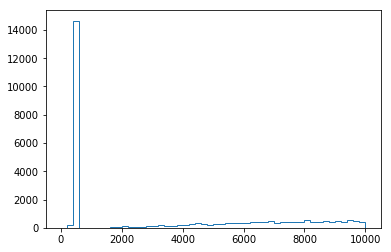

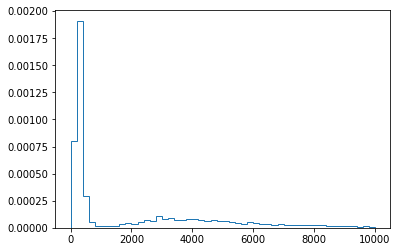

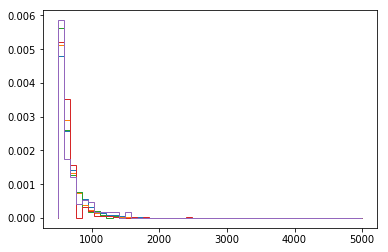

In [14]:
sampel_key = 'all'
#plt.hist(xs_dict_old[sampel_key][:,0], bins=50, weights=xs_dict_old[sampel_key][:,-1], histtype='step', label='signal', range=(0, 10000), density = False) # blue
plt.hist(xs_dict_new[sampel_key][:,0], bins=50, weights=xs_dict_new[sampel_key][:,-1], histtype='step', label='signal', range=(0, 10000), density = False) # orange
plt.show()

# bkg
sampel_key = 'all'
#plt.hist(xb_dict_old[sampel_key][:,0], bins=50, weights=xb_dict_old[sampel_key][:,-1], histtype='step', label='signal', range=(0, 10000), density = True)
plt.hist(xb_dict_new[sampel_key][:,0], bins=50, weights=xb_dict_new[sampel_key][:,-1], histtype='step', label='signal', range=(0, 10000), density = True)
plt.show()

sampel_key = 'di_boson'
plt.hist(xb_dict_old[sampel_key][:,0], bins=50, weights=xb_dict_old[sampel_key][:,-1], histtype='step', label='signal', range=(500, 5000), density = True)
sampel_key = 'drell_yan'
plt.hist(xb_dict_old[sampel_key][:,0], bins=50, weights=xb_dict_old[sampel_key][:,-1], histtype='step', label='signal', range=(500, 5000), density = True)
sampel_key = 'top_quark'
plt.hist(xb_dict_old[sampel_key][:,0], bins=50, weights=xb_dict_old[sampel_key][:,-1], histtype='step', label='signal', range=(500, 5000), density = True)
sampel_key = 'w_jets'
plt.hist(xb_dict_old[sampel_key][:,0], bins=50, weights=xb_dict_old[sampel_key][:,-1], histtype='step', label='signal', range=(500, 5000), density = True)
sampel_key = 'z_ll'
plt.hist(xb_dict_old[sampel_key][:,0], bins=50, weights=xb_dict_old[sampel_key][:,-1], histtype='step', label='signal', range=(500, 5000), density = True)
plt.show()

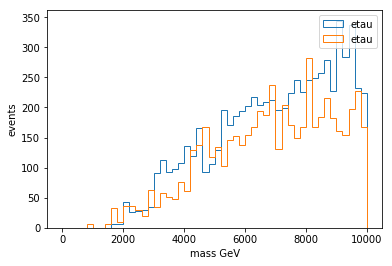

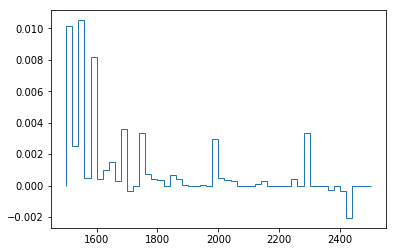

(155328, 24)
(288847, 24)


In [6]:
xs_emu = modify_array(xs_dict_new['all'], weight_id = -1, select_channel = True, channel_id = -4)
xb_emu = modify_array(xb_dict_new['all'], weight_id = -1, select_channel = True, channel_id = -4)
xs_etau = modify_array(xs_dict_new['all'], weight_id = -1, select_channel = True, channel_id = -3)
xb_etau = modify_array(xb_dict_new['all'], weight_id = -1, select_channel = True, channel_id = -3)
xs_mutau = modify_array(xs_dict_new['all'], weight_id = -1, select_channel = True, channel_id = -2)
xb_mutau = modify_array(xb_dict_new['all'], weight_id = -1, select_channel = True, channel_id = -2)

plt.hist(xs_etau[:,0], bins=50, weights=xs_etau[:,-1], histtype='step', label='etau', range=(0, 10000), density = False)
plt.hist(xs_mutau[:,0], bins=50, weights=xs_mutau[:,-1], histtype='step', label='etau', range=(0, 10000), density = False)
plt.legend(prop={'size': 10})
plt.xlabel("mass GeV")
plt.ylabel("events")
plt.show()

plt.hist(xb_emu[:,0], bins=50, weights=xb_emu[:,-1], histtype='step', label='signal', range=(1500, 2500), density = True)
plt.show()

print xb_dict_new['all'].shape
print xb_dict_old['all'].shape

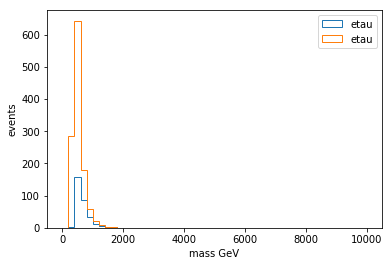

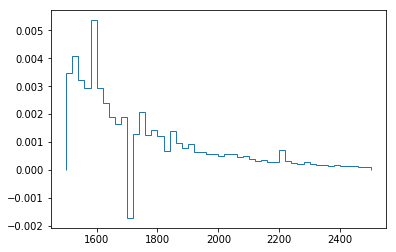

In [7]:
xs_emu = modify_array(xs_dict_old['all'], weight_id = -1, select_channel = True, channel_id = -4)
xb_emu = modify_array(xb_dict_old['all'], weight_id = -1, select_channel = True, channel_id = -4)
xs_etau = modify_array(xs_dict_old['all'], weight_id = -1, select_channel = True, channel_id = -3)
xb_etau = modify_array(xb_dict_old['all'], weight_id = -1, select_channel = True, channel_id = -3)
xs_mutau = modify_array(xs_dict_old['all'], weight_id = -1, select_channel = True, channel_id = -2)
xb_mutau = modify_array(xb_dict_old['all'], weight_id = -1, select_channel = True, channel_id = -2)

plt.hist(xs_etau[:,0], bins=50, weights=xs_etau[:,-1], histtype='step', label='etau', range=(0, 10000), density = False)
plt.hist(xs_mutau[:,0], bins=50, weights=xs_mutau[:,-1], histtype='step', label='etau', range=(0, 10000), density = False)
plt.legend(prop={'size': 10})
plt.xlabel("mass GeV")
plt.ylabel("events")
plt.show()

plt.hist(xb_emu[:,0], bins=50, weights=xb_emu[:,-1], histtype='step', label='signal', range=(1500, 2500), density = True)
plt.show()

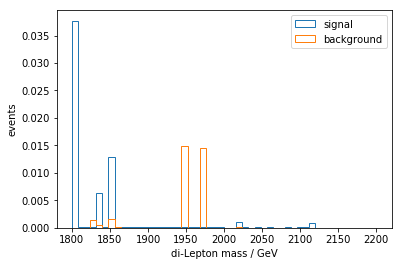

'\nMakePlots(xs_emu, xb_emu, 1, bins = 50, range = (0, 1000)  , density = True,\n          xlabel="Ele_pt / GeV"          , ylabel="Events"  , show_plot = True)\nMakePlots(xs_emu, xb_emu, 2, bins = 50, range = (-3, 3)    , density = True,\n          xlabel="Ele_eta"               , ylabel="Events"  , show_plot = True)\nMakePlots(xs_emu, xb_emu, 3, bins = 50, range = (-3.2, 3.2), density = True,\n          xlabel="Ele_phi"               , ylabel="Events"  , show_plot = True)\nMakePlots(xs_emu, xb_emu, 5, bins = 50, range = (0, 5000)  , density = True,\n          xlabel="Mu_pt / GeV"           , ylabel="Events"  , show_plot = True)\nMakePlots(xs_emu, xb_emu, 6, bins = 50, range = (-3, 3)    , density = True,\n          xlabel="Mu_eta"                , ylabel="Events"  , show_plot = True)\nMakePlots(xs_emu, xb_emu, 7, bins = 50, range = (-3.2, 3.2), density = True,\n          xlabel="Mu_phi"                , ylabel="Events"  , show_plot = True)\n\nMakePlots(xs_emu, xb_emu, 15, bins = 50, 

In [78]:
xs_emu = modify_array(xb_dict_old['all'], weight_id = -1, select_channel = True, channel_id = -2,
                      norm = True, shuffle = True, shuffle_seed = int(time.time()))
xb_emu = modify_array(xb_dict_new['all'], weight_id = -1, remove_negative_weight = True, select_channel = True, channel_id = -2,
                      norm = True, shuffle = True)
#"""
MakePlots(xs_emu, xb_emu, 0, bins = 50, range = (1800, 2200)  , density = False,
          xlabel = "di-Lepton mass / GeV", ylabel = "events", show_plot = True)
"""
MakePlots(xs_emu, xb_emu, 1, bins = 50, range = (0, 1000)  , density = True,
          xlabel="Ele_pt / GeV"          , ylabel="Events"  , show_plot = True)
MakePlots(xs_emu, xb_emu, 2, bins = 50, range = (-3, 3)    , density = True,
          xlabel="Ele_eta"               , ylabel="Events"  , show_plot = True)
MakePlots(xs_emu, xb_emu, 3, bins = 50, range = (-3.2, 3.2), density = True,
          xlabel="Ele_phi"               , ylabel="Events"  , show_plot = True)
MakePlots(xs_emu, xb_emu, 5, bins = 50, range = (0, 5000)  , density = True,
          xlabel="Mu_pt / GeV"           , ylabel="Events"  , show_plot = True)
MakePlots(xs_emu, xb_emu, 6, bins = 50, range = (-3, 3)    , density = True,
          xlabel="Mu_eta"                , ylabel="Events"  , show_plot = True)
MakePlots(xs_emu, xb_emu, 7, bins = 50, range = (-3.2, 3.2), density = True,
          xlabel="Mu_phi"                , ylabel="Events"  , show_plot = True)

MakePlots(xs_emu, xb_emu, 15, bins = 50, range = (0, 1000)  , density = True,
          xlabel="di-Lepton_pt"          , ylabel="Events"  , show_plot = True)
MakePlots(xs_emu, xb_emu, 16, bins = 50, range = (-3, 3)    , density = True,
          xlabel="di-Lepton_eta"         , ylabel="Events"  , show_plot = True)
MakePlots(xs_emu, xb_emu, 17, bins = 50, range = (-3.2, 3.2), density = True,
          xlabel="di-Lepton_phi"         , ylabel="Events"  , show_plot = True)
MakePlots(xs_emu, xb_emu, 18, bins = 50, range = (-3.2, 3.2), density = True,
          xlabel="di-Lepton_Dphi"        , ylabel="Events"  , show_plot = True)
MakePlots(xs_emu, xb_emu, 18, bins = 50, range = (0, 5)     , density = True,
          xlabel="di-Lepton_DR"          , ylabel="Events"  , show_plot = True)
"""

# Training Test

## 1 - Train with individual mass point (new vs old)

In [21]:
selected_features_emu = [0, 1, 2, 3, 5, 6, 7, 15, 16, 17, 18, 19]
selected_features_etau = [0, 1, 2, 3, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19]
selected_features_mutau = [0, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19]

def train_single_mass(sig_dict, bkg_dict, channel_name, channel_id, mass_name, model_name, epochs=20,
                      selected_features = [0, 1, 2, 3, 5, 6, 7, 15, 16, 17, 18, 19], select_bkg_mass = True,
                      self_defined_mass = False, minm = None, maxm = None):
    print "Training {}.".format(channel_name)
    # get data
    print "Loading signal."
    xs_emu = modify_array(sig_dict[mass_name], weight_id = -1, select_channel = True, channel_id = channel_id,
                          norm = True, shuffle = True, shuffle_seed = int(time.time()))
    mass_min, mass_max = get_mass_range(xs_emu[:, 0], xs_emu[:, -1])
    num = 0
    total = 0
    for x in xs_emu[:, 0]:
        #if x > 15000:
        #    print "huge mass:", x
        total += x
        num += 1.0
    print total / num
    print "mass average:", np.average(xs_emu[:, 0], weights=xs_emu[:, -1])
    if self_defined_mass:
        mass_min = minm
        mass_max = maxm
    if select_bkg_mass:
        print "Loading background with mass range:", mass_min, "to", mass_max
    xb_emu = modify_array(bkg_dict['all'], weight_id = -1, remove_negative_weight = True, select_channel = True, channel_id = channel_id,
                          select_mass = select_bkg_mass, mass_id = 0, mass_min = mass_min, mass_max = mass_max,
                          reset_mass = True, reset_mass_array = xs_emu, reset_mass_id = 0,
                          norm = True, shuffle = True, shuffle_seed = int(time.time()))
    # set model and train
    model_deep = model.model_0913(model_name, len(selected_features))
    model_deep.compile()
    model_deep.prepare_array(xs_emu, xb_emu, selected_features)
    model_deep.train(epochs = epochs, val_split = 0.1, verbose = 0)
    # save model
    model_deep.save_model("/mnt/e/data/new_ntuple/model/" + model_name + ".h5")
    # performance plots
    model_deep.show_performance()
    print "\nDone."

### A) mass = 500 GeV

#### a) old ntuple
[emu]

Training emu.
Loading signal.
493.8855792993265
mass average: 493.8480739155169
Loading background with mass range: 466.7931037443082 to 520.9030440867257
Training array prepared.
> signal shape: (8284, 12)
> background shape: (5182, 12)
Training start. Using model: model_mass_500_emu
Model info: Sequential model optimized with old ntuple at Sep. 9th 2019
Training finished.
Quick evaluation:
> test loss: 0.09622921123990061
> test accuracy: 0.659985152145802
model: model_mass_500_emu has been saved to: /mnt/e/data/new_ntuple/model/model_mass_500_emu.h5
Model performance:


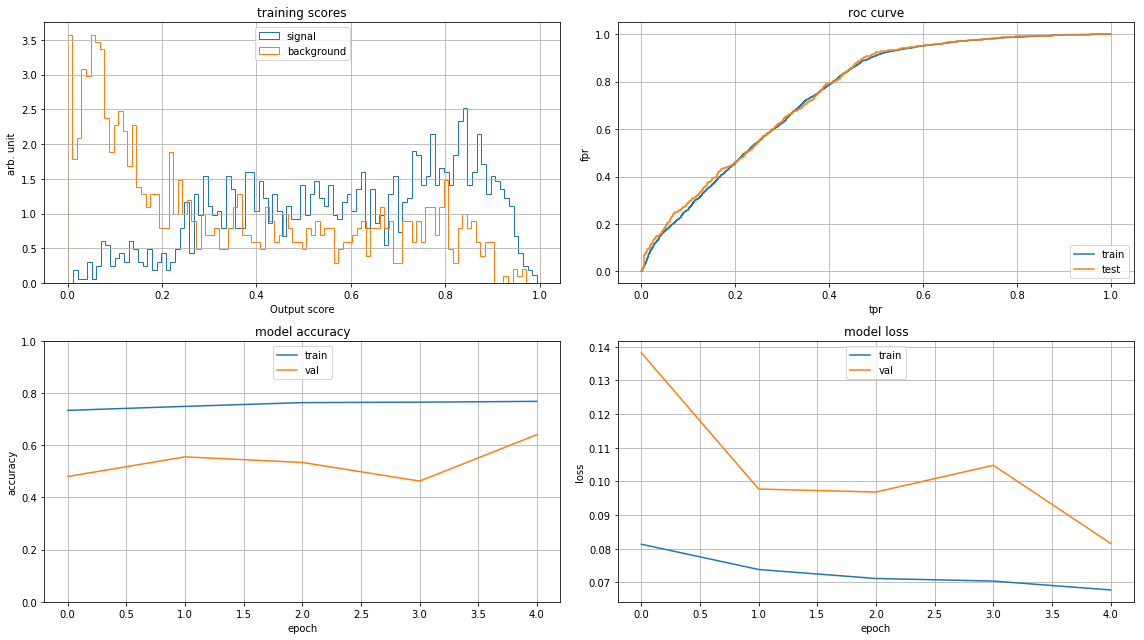

> auc for train: 0.7505794640960517
> auc for test:  0.7555579351560169

Done.


In [24]:
#"""
from lfv_pdnn_code_v1.train import model, train_utils
from lfv_pdnn_code_v1.train.train_utils import *

reload(model)
reload(print_helper)
reload(train_utils)
from lfv_pdnn_code_v1.train.train_utils import *
#"""
model = train_single_mass(xs_dict_old, xb_dict_old, 'emu', -4, '500GeV', "model_mass_500_emu", epochs=5,
                          selected_features = selected_features_emu)


*************************
[etau]

Training etau.
Loading signal.
Loading background with mass range: 463.0026904574336 to 536.4755477217315
Training array prepared.
> signal shape: (1027, 14)
> background shape: (2957, 14)
Training start. Using model: model_mass_500_etau
Model info: Sequential model optimized with old ntuple at Sep. 9th 2019
Training finished.
Quick evaluation:
> test loss: 0.2843022514181328
> test accuracy: 0.7706766923268636
Model performance:


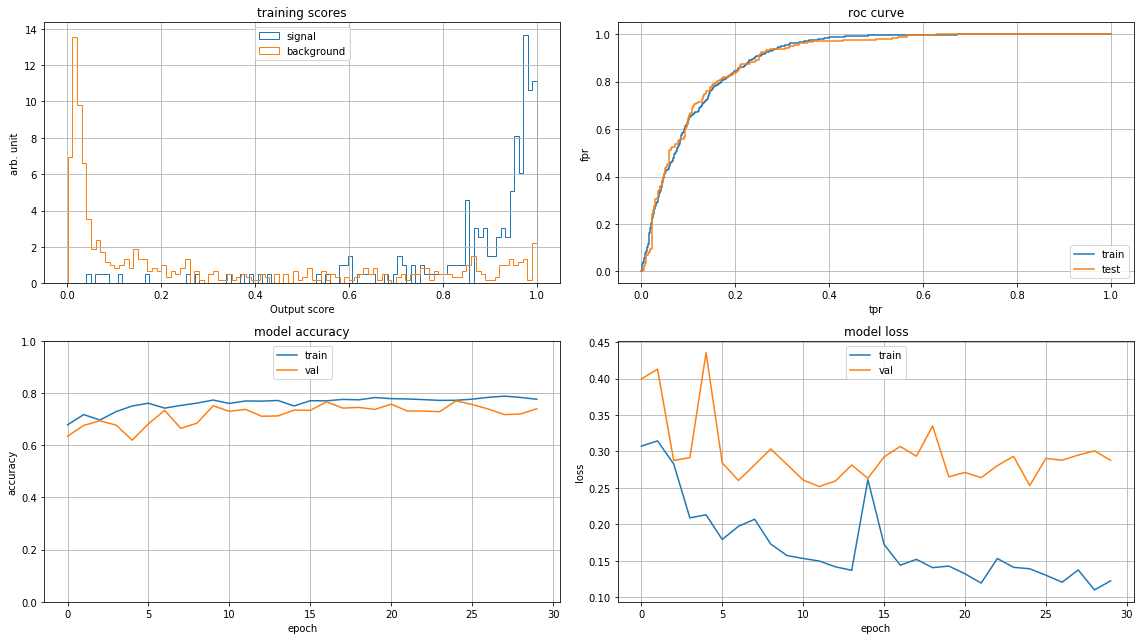

> auc for train: 0.8979674660664945
> auc for test:  0.8957622671214904

Done.


In [12]:
train_single_mass(xs_dict_old, xb_dict_old, 'etau', -3, '500GeV', "model_mass_500_etau", epochs=30, selected_features = selected_features_etau)

**********
[mutau]

Training mutau.
Loading signal.
Loading background with mass range: 342.87881815704503 to 472.177950616332
Training array prepared.
> signal shape: (4553, 14)
> background shape: (8532, 14)
Training start. Using model: model_mass_500_mutau
Model info: Sequential model optimized with old ntuple at Sep. 9th 2019
Training finished.
Quick evaluation:
> test loss: 0.04338613268190026
> test accuracy: 0.8086325437445236
Model performance:


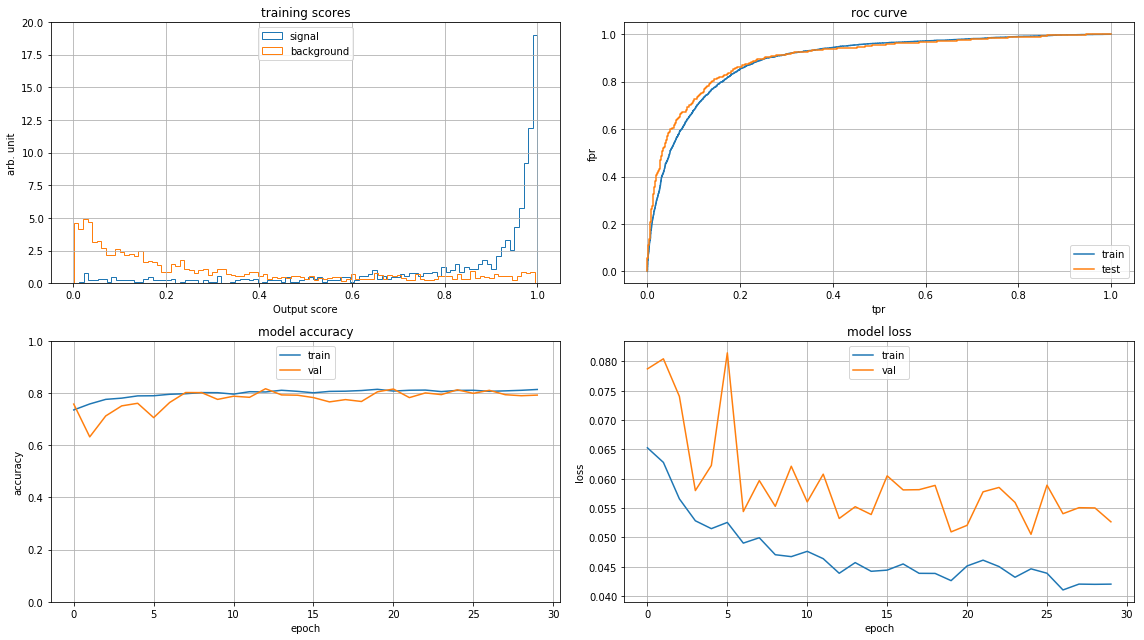

> auc for train: 0.8938724043666382
> auc for test:  0.9020479371761012

Done.


In [16]:
train_single_mass(xs_dict_old, xb_dict_old, 'mutau', -2, '500GeV', "model_mass_500_mutau", epochs=30, selected_features = selected_features_mutau)

#### b) new ntuple
[emu]

Training emu.
Loading signal.
494.4784049169863
mass average: 494.5222994268154
Loading background with mass range: 469.3028976814427 to 519.7417011721881
Training array prepared.
> signal shape: (2223, 12)
> background shape: (2464, 12)
Training start. Using model: model_mass_500_emu_new
Model info: Sequential model optimized with old ntuple at Sep. 9th 2019
Training finished.
Quick evaluation:
> test loss: 0.22335463558941254
> test accuracy: 0.739872068357366
Model performance:


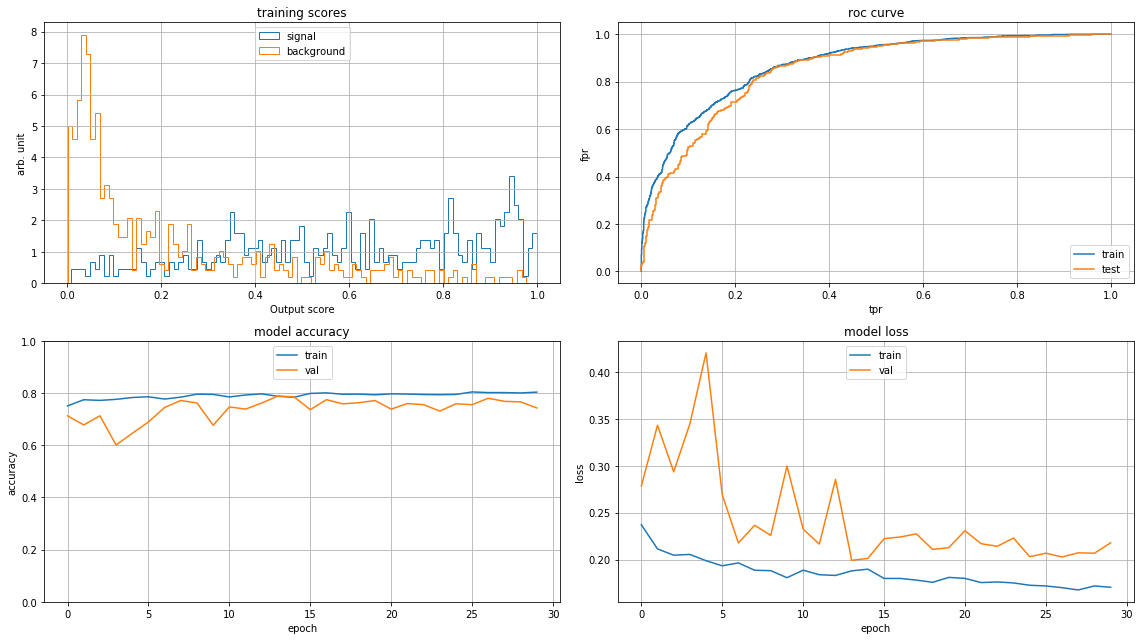

> auc for train: 0.8723136206147748
> auc for test:  0.8500672334024659

Done.


In [13]:
train_single_mass(xs_dict_new, xb_dict_new, 'emu', -4, '500GeV', "model_mass_500_emu_new", epochs=30, selected_features = selected_features_emu)

***********
[etau]

Training etau.
Loading signal.
8912.758543625388
mass average: 8915.972797937442
Loading background with mass range: 6056.148396268443 to 11775.79719960644
Training array prepared.
> signal shape: (3528, 14)
> background shape: (28184, 14)
Training start. Using model: model_mass_500_etau_new
Model info: Sequential model optimized with old ntuple at Sep. 9th 2019
Training finished.
Quick evaluation:
> test loss: 0.03049794270714412
> test accuracy: 0.7753428977106753
Model performance:


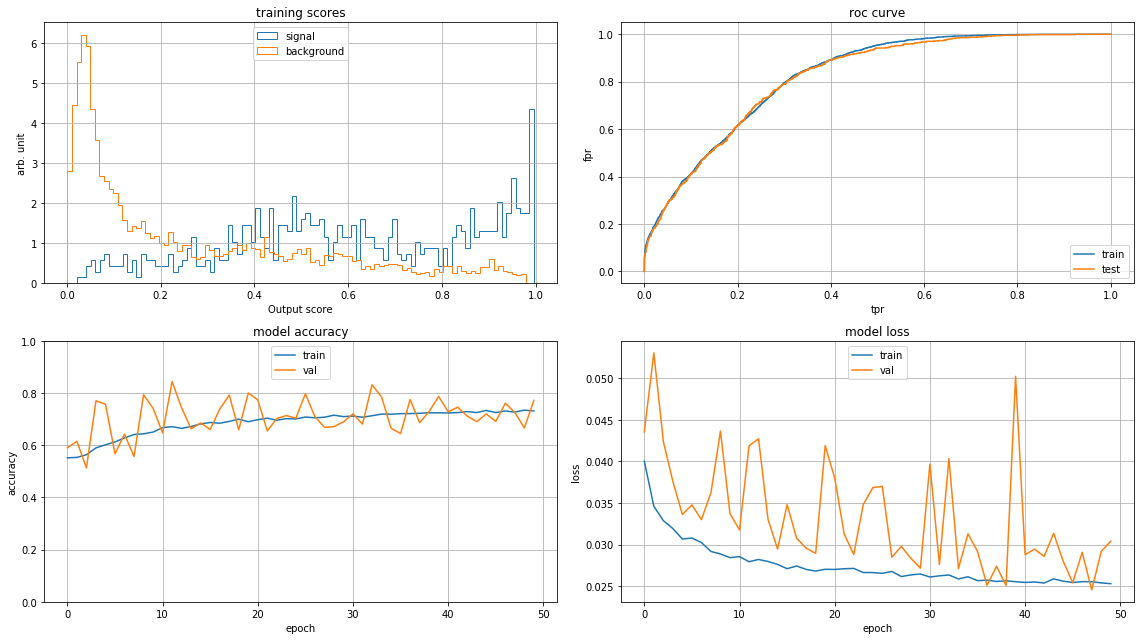

> auc for train: 0.8228760007012048
> auc for test:  0.817577961475701

Done.


In [20]:
train_single_mass(xs_dict_new, xb_dict_new, 'etau', -3, '500GeV', "model_mass_500_etau_new", epochs=30, selected_features = selected_features_etau)

*********
[mutau]

Training mutau.
Loading signal.
407.84370558209076
mass average: 408.09531934215124
Loading background with mass range: 343.92428895110277 to 472.2663497331997
Training array prepared.
> signal shape: (3228, 14)
> background shape: (10600, 14)
Training start. Using model: model_mass_500_mutau_new
Model info: Sequential model optimized with old ntuple at Sep. 9th 2019
Training finished.
Quick evaluation:
> test loss: 0.18468709743634912
> test accuracy: 0.29934924082400916
Model performance:


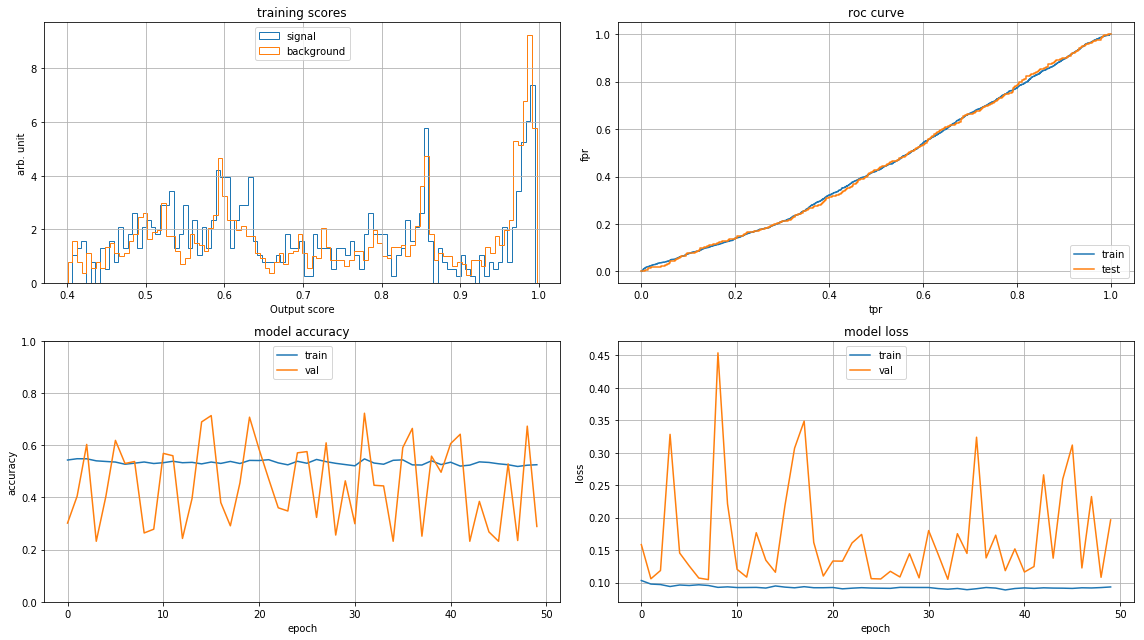

> auc for train: 0.454133980898236
> auc for test:  0.45355306968865006

Done.


In [19]:
train_single_mass(xs_dict_new, xb_dict_new, 'mutau', -2, '500GeV', "model_mass_500_mutau_new", epochs=30, selected_features = selected_features_mutau)

### B) mass = 2000 GeV

#### a) old ntuple
[emu]

Training emu.
Loading signal.
1991.0730829343865
mass average: 1992.6490992829763
Loading background with mass range: 1770.8888168538374 to 2214.409381712115
Training array prepared.
> signal shape: (9945, 12)
> background shape: (12926, 12)
Training start. Using model: model_mass_2000_emu
Model info: Sequential model optimized with old ntuple at Sep. 9th 2019
Training finished.
Quick evaluation:
> test loss: 0.035295177452225504
> test accuracy: 0.8233879779596798
Model performance:


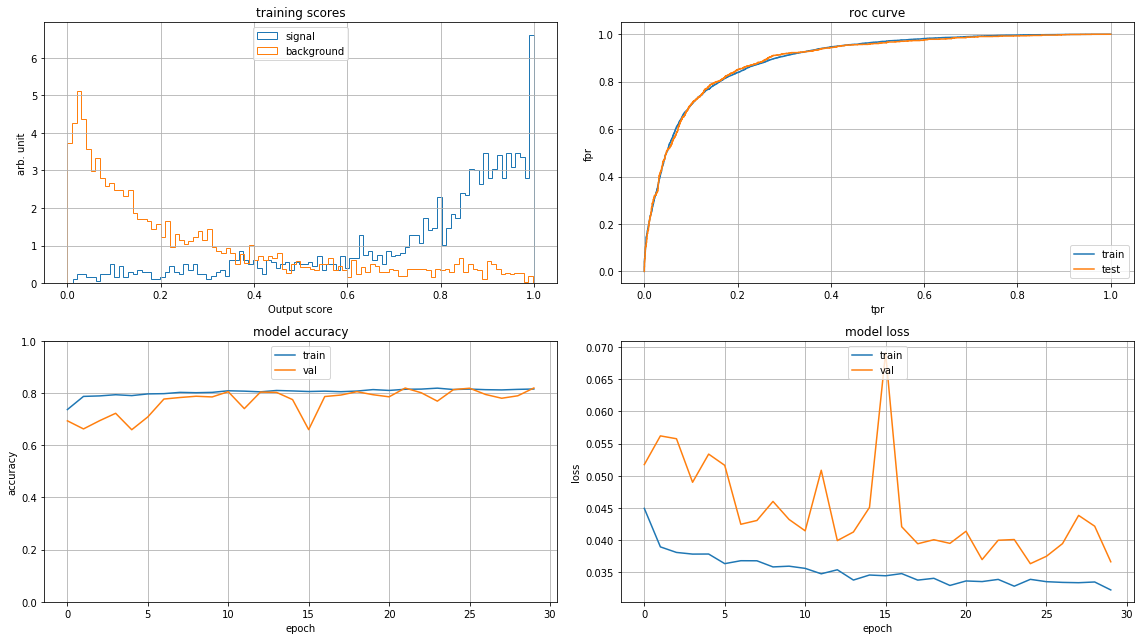

> auc for train: 0.8969088327192207
> auc for test:  0.8960152843734119

Done.


In [15]:
train_single_mass(xs_dict_old, xb_dict_old, 'emu', -4, '2000GeV', "model_mass_2000_emu", epochs=30, 
                  selected_features = selected_features_emu, select_bkg_mass = True,
                  self_defined_mass = False, minm = 1800, maxm = 2200)

*********
[etau] 

Training etau.
Loading signal.
1945.8074501740666
mass average: 1936.4430786674295
Loading background with mass range: 1623.7818709990136 to 2249.1042863358457
Training array prepared.
> signal shape: (880, 14)
> background shape: (4547, 14)
Training start. Using model: model_mass_2000_etau
Model info: Sequential model optimized with old ntuple at Sep. 9th 2019
Training finished.
Quick evaluation:
> test loss: 0.39008889118171747
> test accuracy: 0.837937384240096
Model performance:


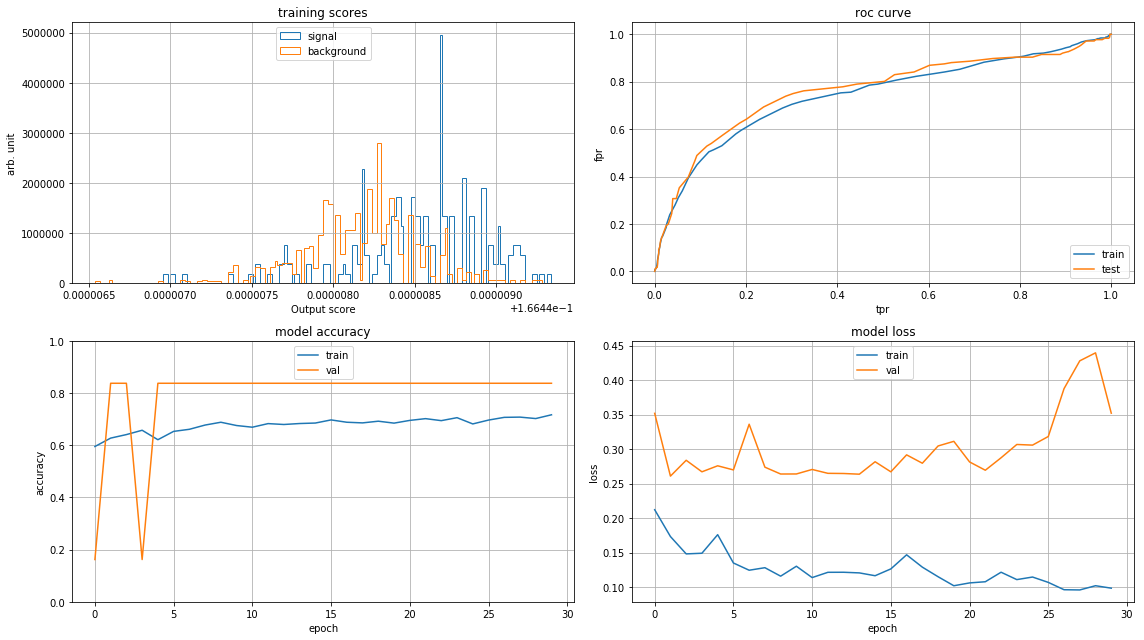

> auc for train: 0.7427497063013974
> auc for test:  0.7615509490509491

Done.


In [13]:
train_single_mass(xs_dict_old, xb_dict_old, 'etau', -3, '2000GeV', "model_mass_2000_etau", epochs=30, 
                  selected_features = selected_features_etau, select_bkg_mass = True,
                  self_defined_mass = False, minm = 1800, maxm = 2200)

*********
[mutau]

Training mutau.
Loading signal.
1503.875670297686
mass average: 1505.7730138098846
Loading background with mass range: 1138.578210123003 to 1872.9678174967662
Training array prepared.
> signal shape: (3848, 14)
> background shape: (11291, 14)
Training start. Using model: model_mass_2000_mutau
Model info: Sequential model optimized with old ntuple at Sep. 9th 2019
Training finished.
Quick evaluation:
> test loss: 0.06498423375167167
> test accuracy: 0.5701551668791143
Model performance:


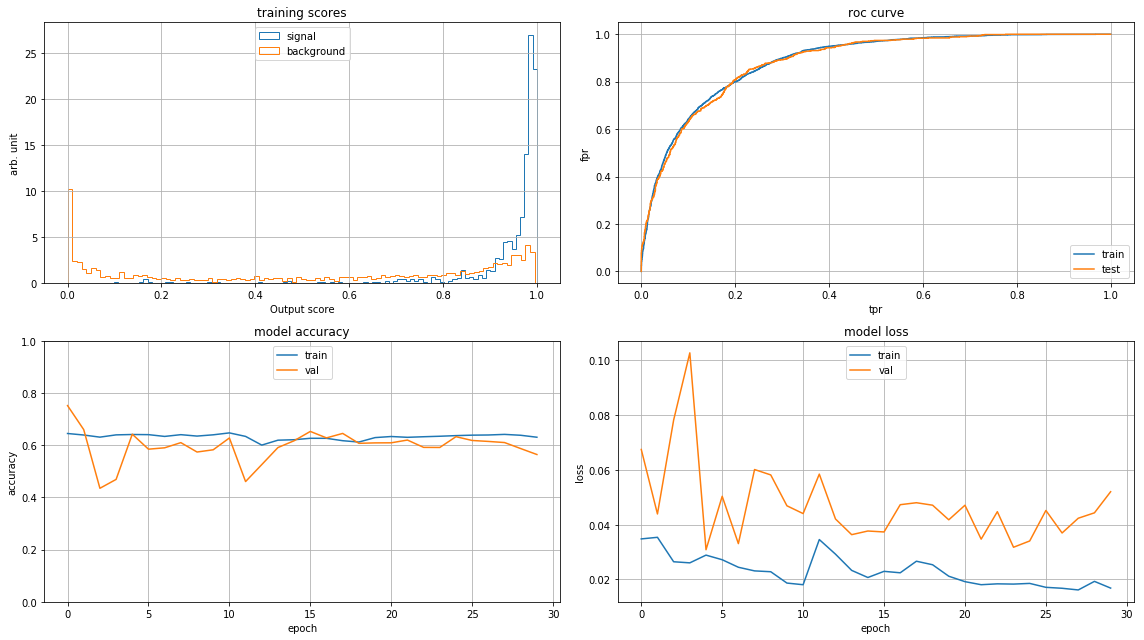

> auc for train: 0.8868262997897591
> auc for test:  0.8845682206239975

Done.


In [11]:
train_single_mass(xs_dict_old, xb_dict_old, 'mutau', -2, '2000GeV', "model_mass_2000_mutau", epochs=30, selected_features = selected_features_mutau)

#### b) new ntuple
[emu] too few background

Training emu.
Loading signal.
1978.1365815790298
mass average: 1978.9081909855297
Loading background with mass range: 1793.958152994272 to 2163.8582289767874
Training array prepared.
> signal shape: (2720, 12)
> background shape: (13, 12)
Training start. Using model: model_mass_2000_emu_new
Model info: Sequential model optimized with old ntuple at Sep. 9th 2019
Training finished.
Quick evaluation:
> test loss: 0.45214125258640353
> test accuracy: 0.9104204753199269
Model performance:


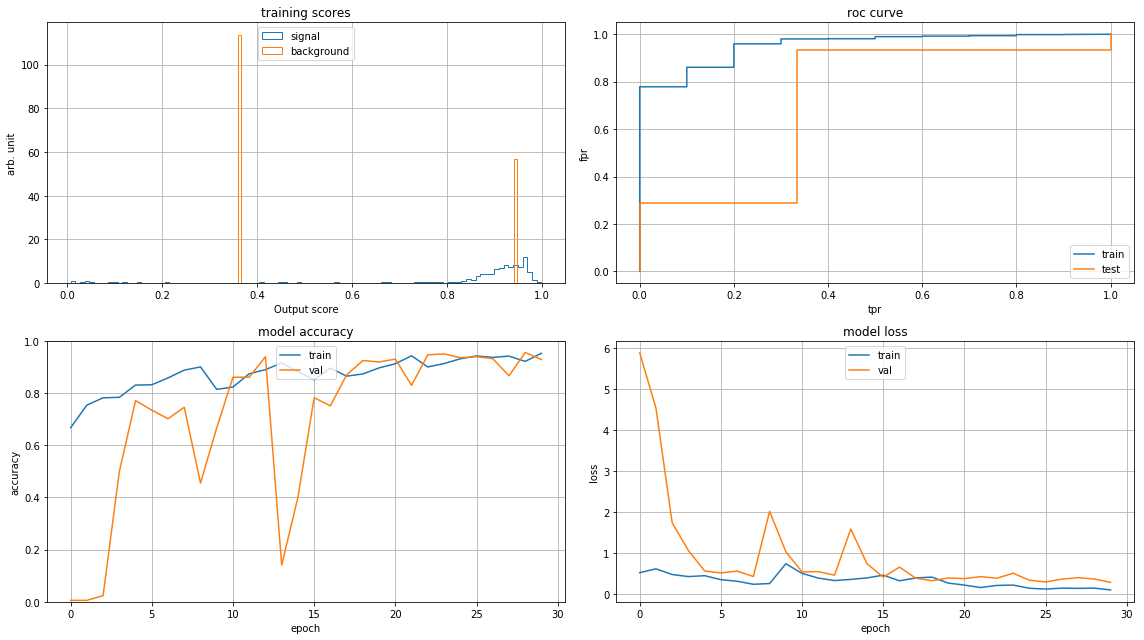

> auc for train: 0.9534466911764707
> auc for test:  0.7199754901960785

Done.


In [16]:
train_single_mass(xs_dict_new, xb_dict_new, 'emu', -4, '2000GeV', "model_mass_2000_emu_new", epochs=30, 
                  selected_features = selected_features_emu, select_bkg_mass = True,
                  self_defined_mass = False, minm = 1800, maxm = 2200)

********
[etau]

Training etau.
Loading signal.
39218.44921671842
mass average: 39214.91563853623
Loading background with mass range: 26187.95188359118 to 52241.87939348128
Training array prepared.
> signal shape: (4427, 14)
> background shape: (5642, 14)
Training start. Using model: model_mass_2000_etau_new
Model info: Sequential model optimized with old ntuple at Sep. 9th 2019
Training finished.
Quick evaluation:
> test loss: 0.008198698206462957
> test accuracy: 0.9905707196029777
Model performance:


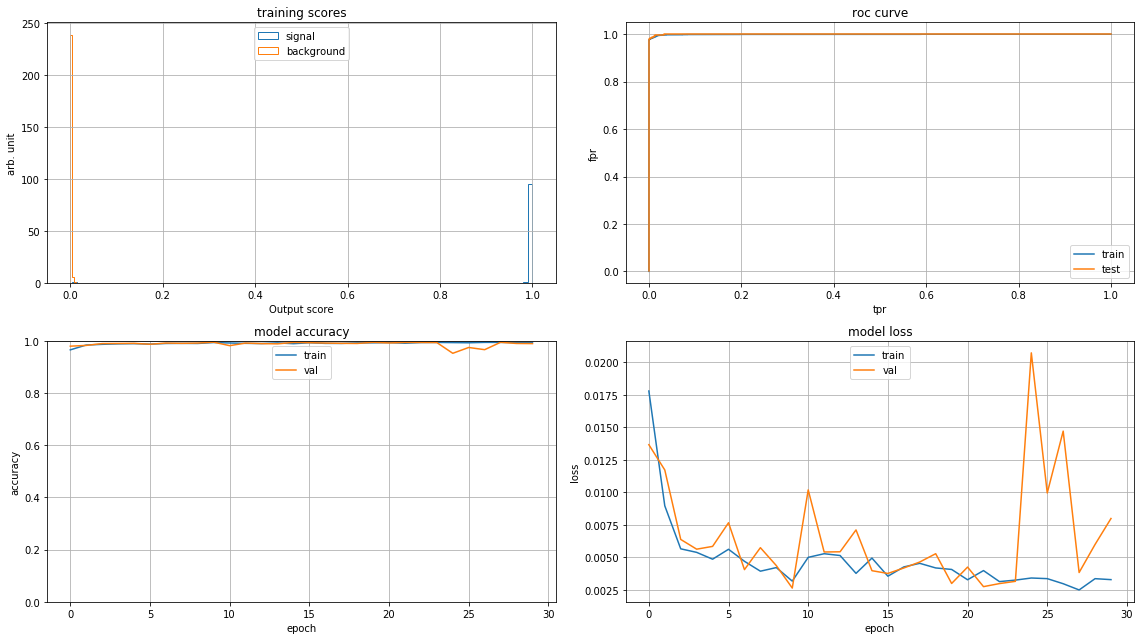

> auc for train: 0.9992789977655939
> auc for test:  0.999776065836644

Done.


In [68]:
train_single_mass(xs_dict_new, xb_dict_new, 'etau', -3, '2000GeV', "model_mass_2000_etau_new", epochs=30, 
                  selected_features = selected_features_etau, select_bkg_mass = True, 
                  self_defined_mass = True, minm = 1800, maxm = 2200)

*******
[mutau]

Training mutau.
Loading signal.
1528.9107180945557
mass average: 1528.7207513777794
Loading background with mass range: 1178.5286919238774 to 1878.9128108316813
Training array prepared.
> signal shape: (3553, 14)
> background shape: (11, 14)
Training start. Using model: model_mass_2000_mutau_new
Model info: Sequential model optimized with old ntuple at Sep. 9th 2019
Training finished.
Quick evaluation:
> test loss: 0.250688290040867
> test accuracy: 0.7422969184335875
Model performance:


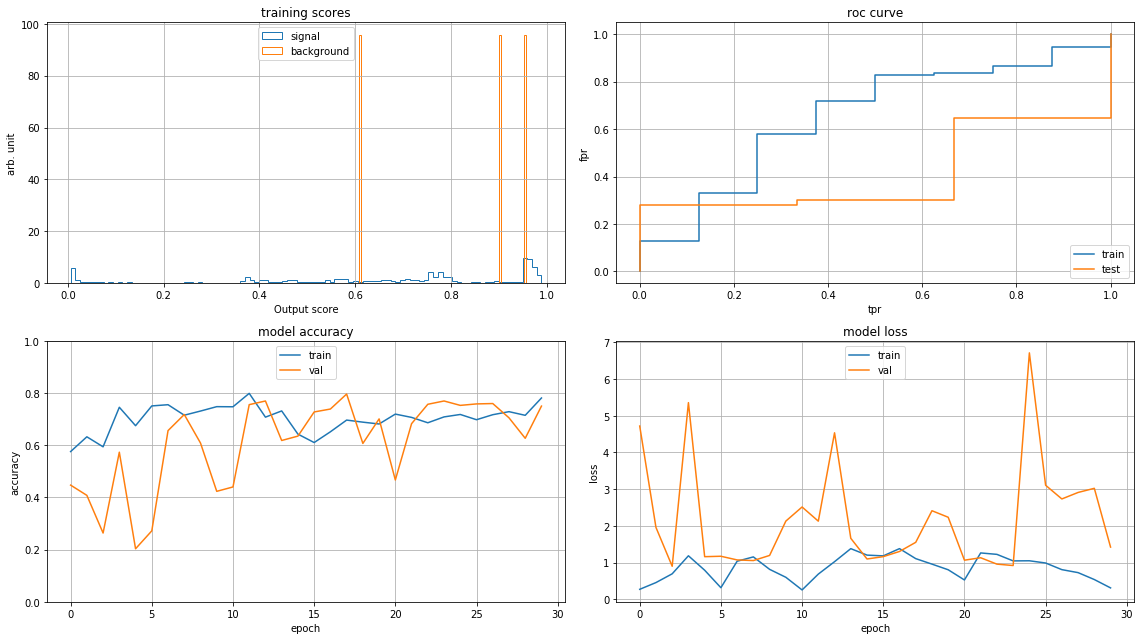

> auc for train: 0.6547325826882477
> auc for test:  0.4092827004219409

Done.


In [70]:
train_single_mass(xs_dict_new, xb_dict_new, 'mutau', -2, '2000GeV', "model_mass_2000_mutau_new", epochs=30, 
                  selected_features = selected_features_mutau, select_bkg_mass = True,
                  self_defined_mass = True, minm = 1800, maxm = 2200)

## 2 - Train with 500 GeV mass point and full mass point (use old ntuple)

### A) Train with 500 GeV single mass point
#### a) emu

Training emu.
Loading signal.
493.8855792993253
mass average: 493.84807391551686
Loading background with mass range: 466.79310374430816 to 520.9030440867256
Training array prepared.
> signal shape: (8284, 12)
> background shape: (5182, 12)
Training start. Using model: model_mass_500_emu_single
Model info: Sequential model optimized with old ntuple at Sep. 9th 2019
Training finished.
Quick evaluation:
> test loss: 0.0782410708942631
> test accuracy: 0.7631774312846291
Model performance:


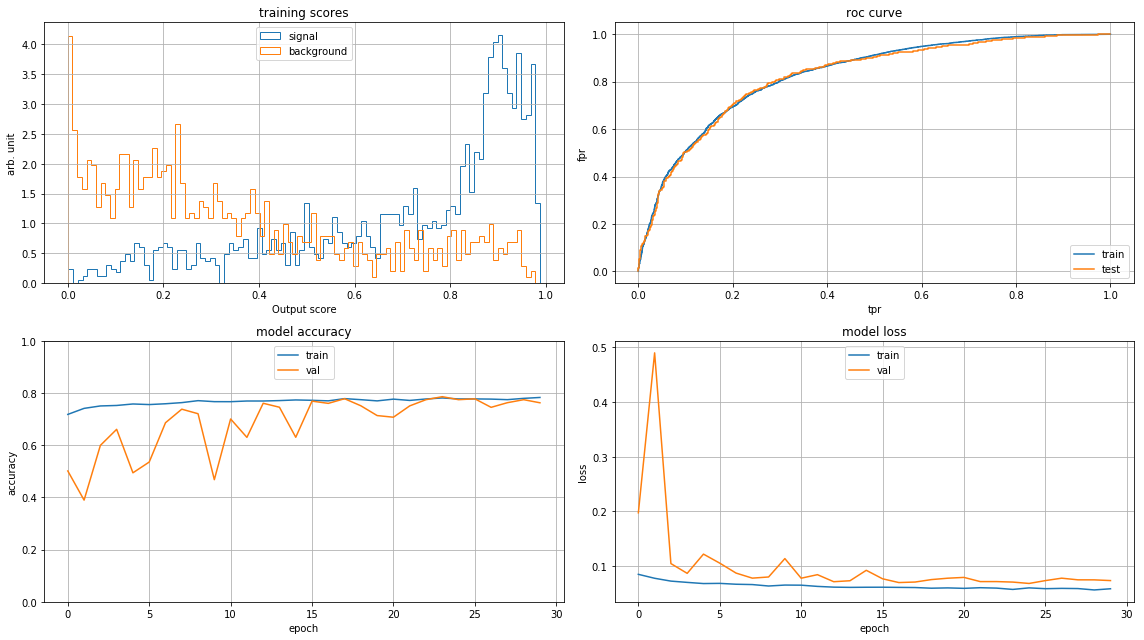

> auc for train: 0.8280302480094318
> auc for test:  0.8237715102464109

Done.


In [33]:
model_single = train_single_mass(xs_dict_old, xb_dict_old, 'emu', -4, '500GeV', "model_mass_500_emu_single", epochs=30, 
                                 selected_features = selected_features_emu, select_bkg_mass = True)

### B) Train with full mass point

Training emu.
Loading signal.
2030.4380062369428
mass average: 656.7965287162732
Loading background with mass range: 416.3921044452358 to 897.2009529873105
Training array prepared.
> signal shape: (239791, 12)
> background shape: (33892, 12)
Training start. Using model: model_mass_all_emu
Model info: Sequential model optimized with old ntuple at Sep. 9th 2019
Training finished.
Quick evaluation:
> test loss: 0.011265813589683637
> test accuracy: 0.7739778581541593
Model performance:


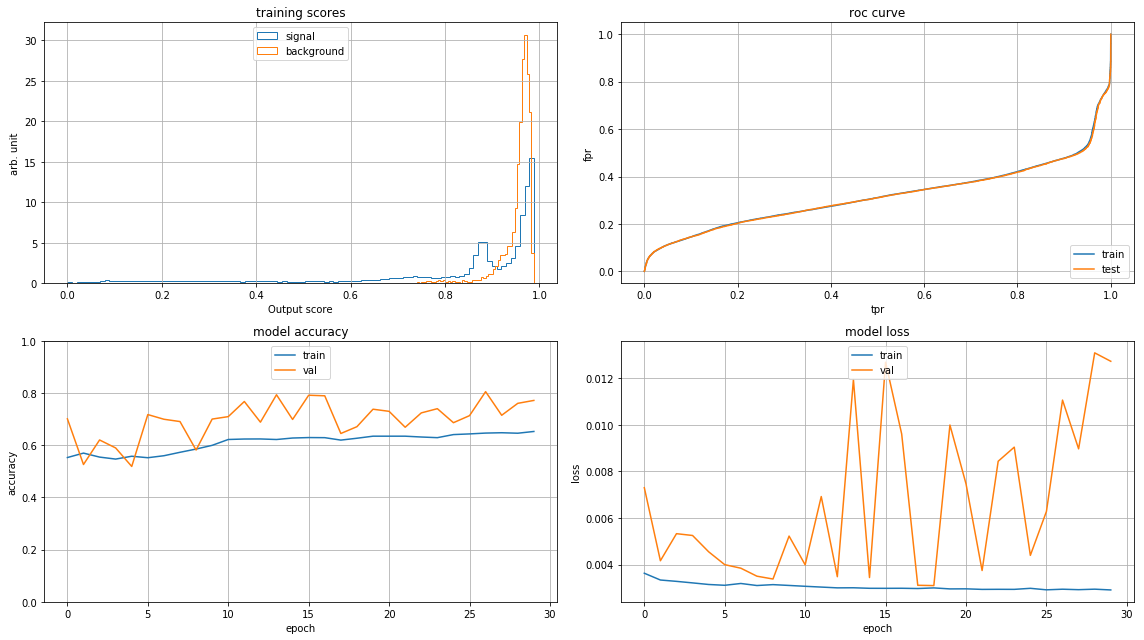

> auc for train: 0.3186195301957951
> auc for test:  0.31714338402607567

Done.


In [42]:
model_total = train_single_mass(xs_dict_old, xb_dict_old, 'emu', -4, 'all', "model_mass_all_emu", epochs=30, 
                                 selected_features = selected_features_emu, select_bkg_mass = True)

### B1) Train with full mass point, normalized before adding all mass point samples

Training emu.
Loading signal.
2030.4380062369746
mass average: 2093.0511324881763
Loading background with mass range: 721.7161278187314 to 3464.3861371576213
Training array prepared.
> signal shape: (239791, 12)
> background shape: (78881, 12)
Training start. Using model: model_mass_all_emu
Model info: Sequential model optimized with old ntuple at Sep. 9th 2019
Training finished.
Quick evaluation:
> test loss: 0.0029277555376071625
> test accuracy: 0.7699259445211497
Model performance:


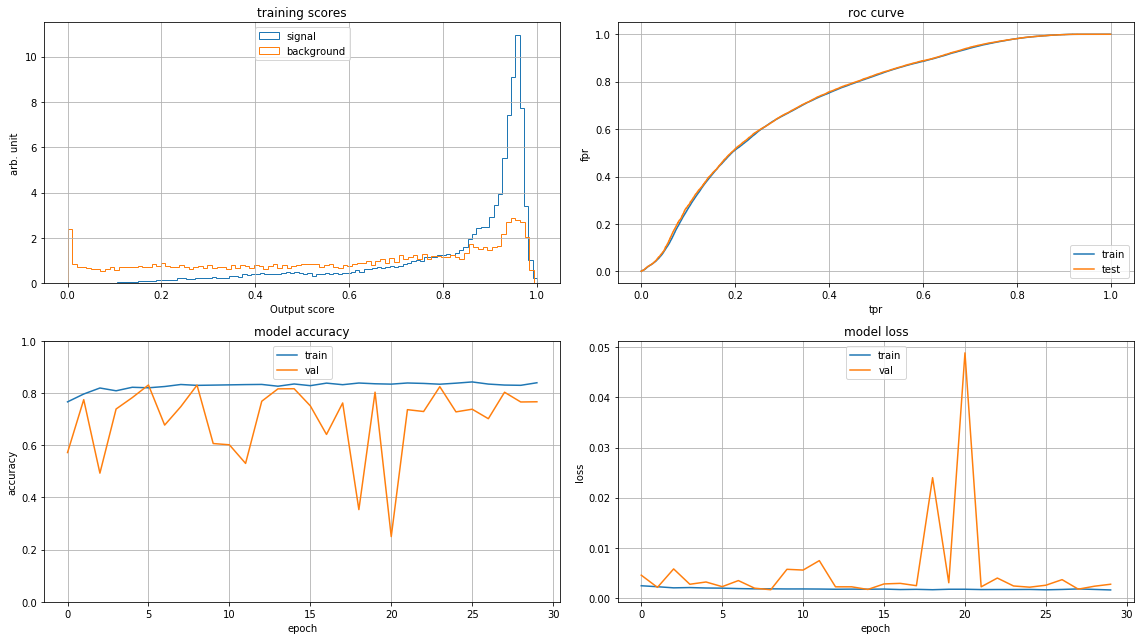

> auc for train: 0.7317777086724491
> auc for test:  0.7346152502019023

Done.


2019-09-24 16:50:34.653413: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-09-24 16:50:34.712494: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2901000000 Hz
2019-09-24 16:50:34.714871: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fffddb4ba70 executing computations on platform Host. Devices:
2019-09-24 16:50:34.715186: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2019-09-24 16:50:35.428796: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) 

In [11]:
model_total_norm = train_single_mass(xs_dict_old, xb_dict_old, 'emu', -4, 'all_norm', "model_mass_all_emu", epochs=30, 
                                 selected_features = selected_features_emu, select_bkg_mass = True)

### B2) Train with max 2400 GeV

Training emu.
Loading signal.
1374.052116238971
mass average: 655.8386925227775
Loading background with mass range: 420.2024132741879 to 891.4749717713671
Training array prepared.
> signal shape: (171068, 12)
> background shape: (33530, 12)
Training start. Using model: model_mass_all_emu
Model info: Sequential model optimized with old ntuple at Sep. 9th 2019
Training finished.
Quick evaluation:
> test loss: 0.003966415845602387
> test accuracy: 0.7193548387096774
Model performance:


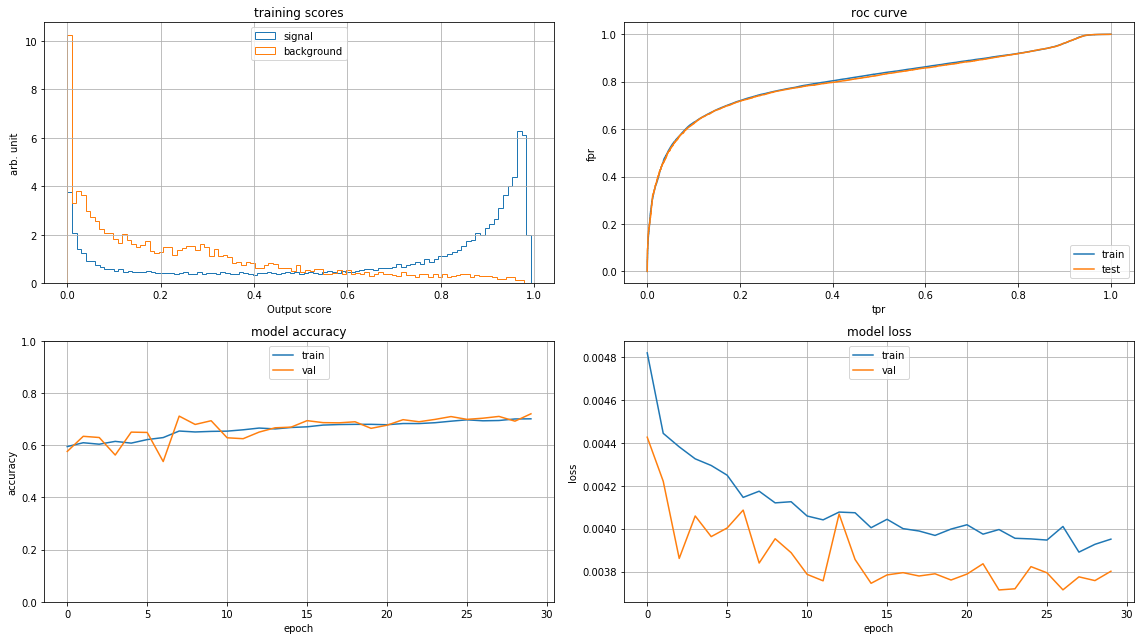

> auc for train: 0.8072071135086192
> auc for test:  0.8040348195427768

Done.


In [62]:
model_max_2400 = train_single_mass(xs_dict_old, xb_dict_old, 'emu', -4, 'max_2400', "model_mass_all_emu", epochs=30, 
                                 selected_features = selected_features_emu, select_bkg_mass = True)

### B3) Train with max 2400 GeV, normalized before adding signal samples together

Training emu.
Loading signal.
1374.052116238973
mass average: 1376.0417084374922
Loading background with mass range: 805.3811457975344 to 1946.70227107745
Training array prepared.
> signal shape: (171068, 12)
> background shape: (39921, 12)
Training start. Using model: model_max_2400_norm
Model info: Sequential model optimized with old ntuple at Sep. 9th 2019
Training finished.
Quick evaluation:
> test loss: 0.0031756766499712818
> test accuracy: 0.8578165359213334
Model performance:


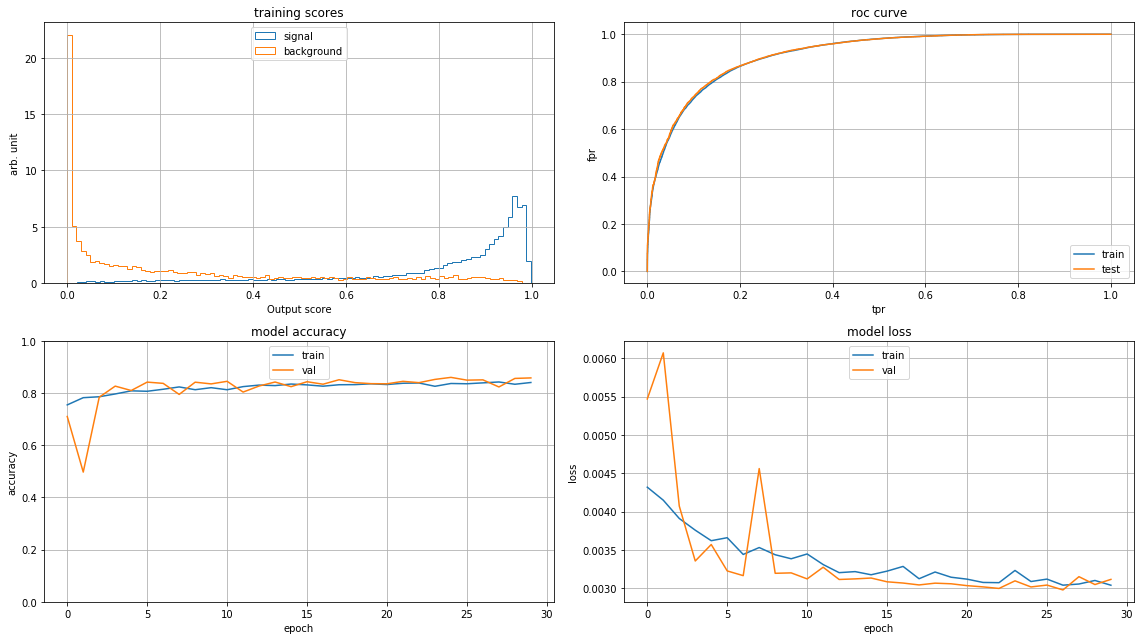

> auc for train: 0.914188504178553
> auc for test:  0.9160872143687019

Done.


In [56]:
model_max_2400_norm = train_single_mass(xs_dict_old, xb_dict_old, 'emu', -4, 'max_2400_norm', "model_max_2400_norm", epochs=30, 
                                 selected_features = selected_features_emu, select_bkg_mass = True)

### B4) train with 3-point (normalized before add)
train with 500, 1000, 2000GeV

Training emu.
Loading signal.
1200.0164482062723
mass average: 1179.9016937958047
Loading background with mass range: 450 to 2200
Training array prepared.
> signal shape: (27806, 12)
> background shape: (78339, 12)
Training start. Using model: model_3_point_norm
Model info: Sequential model optimized with old ntuple at Sep. 9th 2019
Training finished.
Quick evaluation:
> test loss: 0.0054213567291006085
> test accuracy: 0.7596796985454173
Model performance:


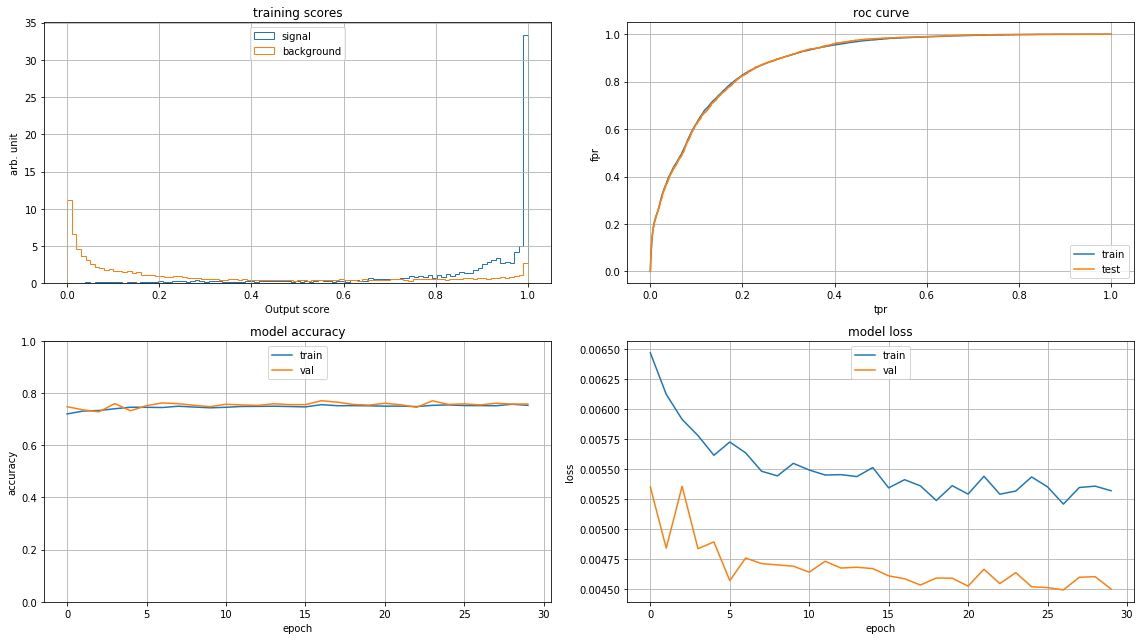

> auc for train: 0.8906669647116126
> auc for test:  0.8906490044180867

Done.


In [12]:
model_3_point_norm = train_single_mass(xs_dict_old, xb_dict_old, 'emu', -4, '3_point_norm', "model_3_point_norm", epochs=30, 
                                       selected_features = selected_features_emu, select_bkg_mass = True, 
                                       self_defined_mass = True, minm = 450, maxm = 2200)

### B4) train with 4-point (normalized before add)
train with 500, 700, 1000, 2000GeV

Training emu.
Loading signal.
1077.1777165185633
mass average: 1061.2381363423897
Loading background with mass range: 450 to 2200
Training array prepared.
> signal shape: (36667, 12)
> background shape: (78339, 12)
Training start. Using model: model_4_point_norm
Model info: Sequential model optimized with old ntuple at Sep. 9th 2019
Training finished.
Quick evaluation:
> test loss: 0.006147240368480444
> test accuracy: 0.7875836883490112
Model performance:


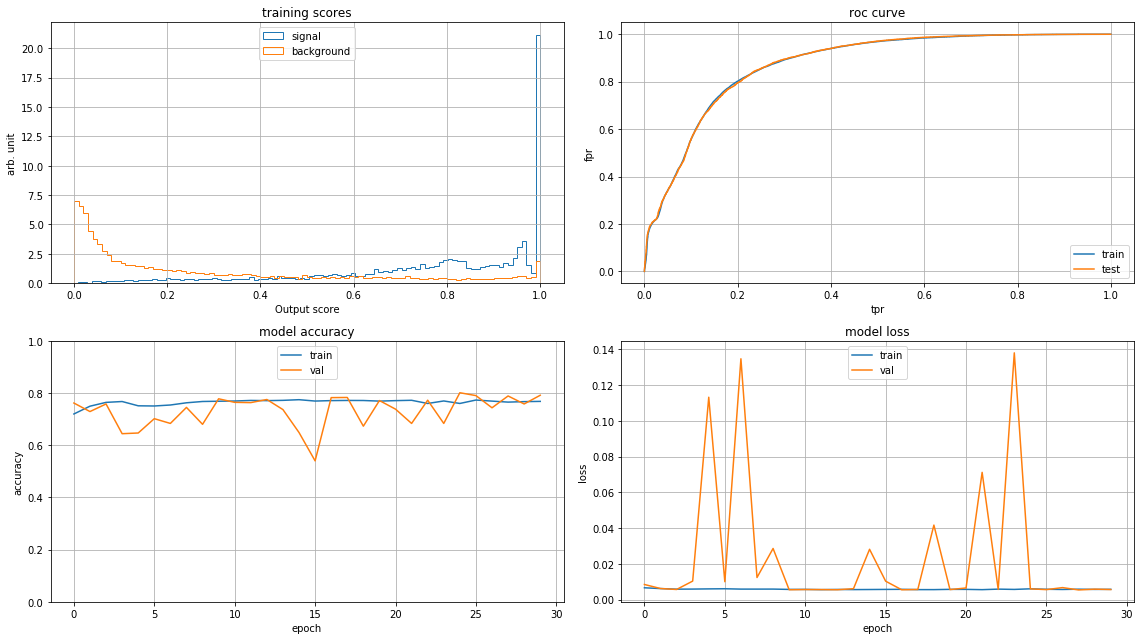

> auc for train: 0.8723165956041294
> auc for test:  0.8726315977448332

Done.


In [18]:
model_4_point_norm = train_single_mass(xs_dict_old, xb_dict_old, 'emu', -4, '4_point_norm', "model_4_point_norm", epochs=30, 
                                       selected_features = selected_features_emu, select_bkg_mass = True, 
                                       self_defined_mass = True, minm = 450, maxm = 2200)

### C) Compare around 500GeV
set mass range to (450, 550)

use model: model_mass_500_emu_single


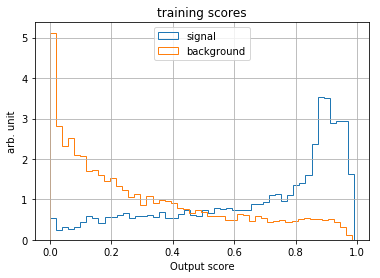

use model: model_mass_all_emu


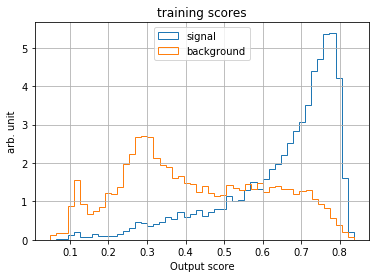

use model: model_max_2400_norm


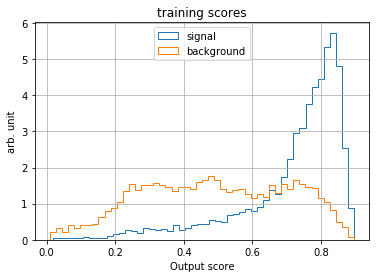

use model: model_3_point_norm


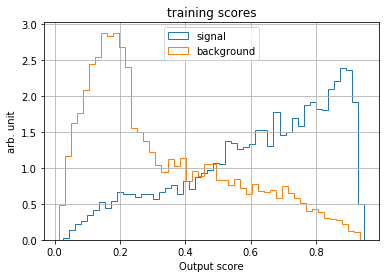

In [66]:
mass_min = 450
mass_max = 550
xs_emu = modify_array(xs_dict_old['all'], weight_id = -1, select_channel = True, channel_id = -4,
                      select_mass = True, mass_id = 0, mass_min = mass_min, mass_max = mass_max)
xb_emu = modify_array(xb_dict_old['all'], weight_id = -1, select_channel = True, channel_id = -4,
                      select_mass = True, mass_id = 0, mass_min = mass_min, mass_max = mass_max)
xs_emu_selected = get_part_feature(xs_emu, selected_features_emu)
xb_emu_selected = get_part_feature(xb_emu, selected_features_emu)

# single mass train model
print "use model:", model_single.model_name
fig, ax = plt.subplots()
ax.hist(model_single.get_model().predict(xs_emu_selected), bins=50, 
        histtype='step', label='signal', density=True)
ax.hist(model_single.get_model().predict(xb_emu_selected), bins=50, 
        histtype='step', label='background', density=True)
ax.set_title('training scores')
ax.legend(loc='upper center')
ax.set_xlabel("Output score")
ax.set_ylabel("arb. unit")
ax.grid()
plt.show()

# full mass train model
print "use model:", model_total_norm.model_name
fig, ax = plt.subplots()
ax.hist(model_total_norm.get_model().predict(xs_emu_selected), bins=50, 
        histtype='step', label='signal', density=True)
ax.hist(model_total_norm.get_model().predict(xb_emu_selected), bins=50, 
        histtype='step', label='background', density=True)
ax.set_title('training scores')
ax.legend(loc='upper center')
ax.set_xlabel("Output score")
ax.set_ylabel("arb. unit")
ax.grid()
plt.show()

# below 2400 mass train model, normed
print "use model:", model_max_2400_norm.model_name
fig, ax = plt.subplots()
ax.hist(model_max_2400_norm.get_model().predict(xs_emu_selected), bins=50, 
        histtype='step', label='signal', density=True)
ax.hist(model_max_2400_norm.get_model().predict(xb_emu_selected), bins=50, 
        histtype='step', label='background', density=True)
ax.set_title('training scores')
ax.legend(loc='upper center')
ax.set_xlabel("Output score")
ax.set_ylabel("arb. unit")
ax.grid()
plt.show()

# 3 mass point train model, normed
print "use model:", model_3_point_norm.model_name
fig, ax = plt.subplots()
ax.hist(model_3_point_norm.get_model().predict(xs_emu_selected), bins=50, 
        histtype='step', label='signal', density=True)
ax.hist(model_3_point_norm.get_model().predict(xb_emu_selected), bins=50, 
        histtype='step', label='background', density=True)
ax.set_title('training scores')
ax.legend(loc='upper center')
ax.set_xlabel("Output score")
ax.set_ylabel("arb. unit")
ax.grid()

## 3 - train with new and old signal to see the result

### A) 500GeV

Training new_vs_old. (emu)
Loading signal.
Training array prepared.
> signal shape: (2223, 12)
> background shape: (8284, 12)
Training start. Using model: new_vs_old
Model info: Sequential model optimized with old ntuple at Sep. 9th 2019
Train on 6303 samples, validate on 2102 samples
Epoch 1/30
6303/6303 [==============================] - 3s 411us/step - loss: 0.1339 - acc: 0.5666 - val_loss: 0.8010 - val_acc: 0.7826
Epoch 2/30
6303/6303 [==============================] - 1s 110us/step - loss: 0.1230 - acc: 0.6011 - val_loss: 1.4541 - val_acc: 0.2174
Epoch 3/30
6303/6303 [==============================] - 1s 106us/step - loss: 0.1158 - acc: 0.6102 - val_loss: 0.7357 - val_acc: 0.2217
Epoch 4/30
6303/6303 [==============================] - 1s 104us/step - loss: 0.1090 - acc: 0.6205 - val_loss: 1.5831 - val_acc: 0.7826
Epoch 5/30
6303/6303 [==============================] - 1s 104us/step - loss: 0.1164 - acc: 0.6146 - val_loss: 1.4995 - val_acc: 0.2179
Epoch 6/30
6303/6303 [============

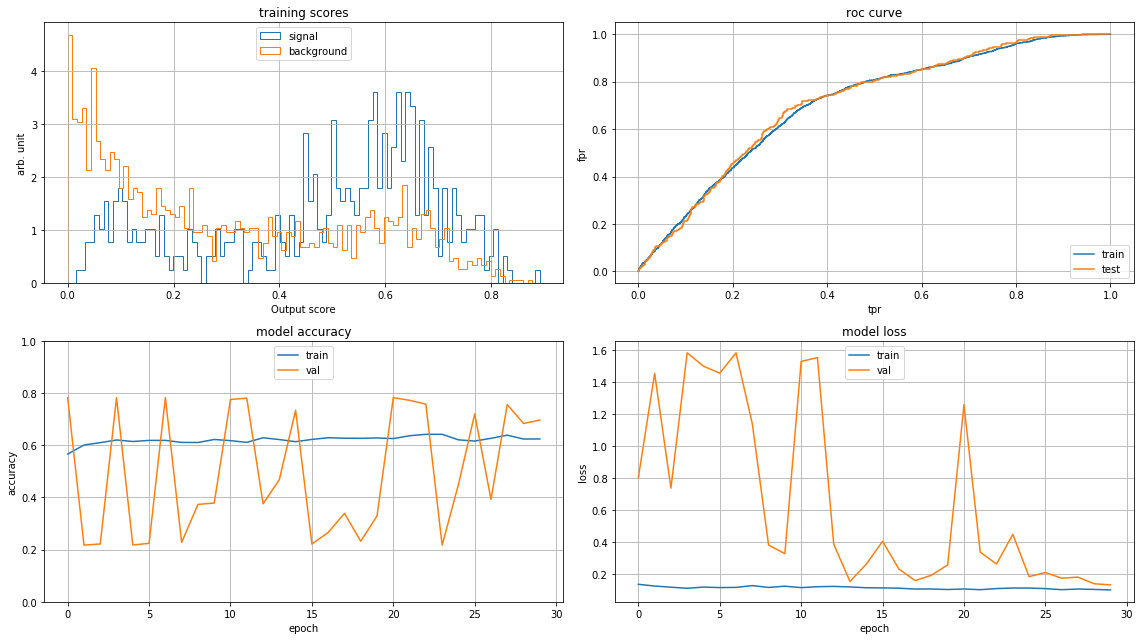

> auc for train: 0.7066181858548803
> auc for test:  0.7108718206044495

Done.
Training old_vs_new.
Training array prepared.
> signal shape: (8284, 12)
> background shape: (2223, 12)
Training start. Using model: olg_vs_new
Model info: Sequential model optimized with old ntuple at Sep. 9th 2019
Train on 6303 samples, validate on 2102 samples
Epoch 1/30
6303/6303 [==============================] - 3s 469us/step - loss: 0.1313 - acc: 0.5867 - val_loss: 1.5325 - val_acc: 0.2041
Epoch 2/30
6303/6303 [==============================] - 1s 107us/step - loss: 0.1254 - acc: 0.5980 - val_loss: 1.4539 - val_acc: 0.7959
Epoch 3/30
6303/6303 [==============================] - 1s 128us/step - loss: 0.1294 - acc: 0.5845 - val_loss: 1.2621 - val_acc: 0.7926
Epoch 4/30
6303/6303 [==============================] - 1s 203us/step - loss: 0.1190 - acc: 0.5970 - val_loss: 0.6255 - val_acc: 0.2317
Epoch 5/30
6303/6303 [==============================] - 1s 153us/step - loss: 0.1167 - acc: 0.6151 - val_loss: 0.

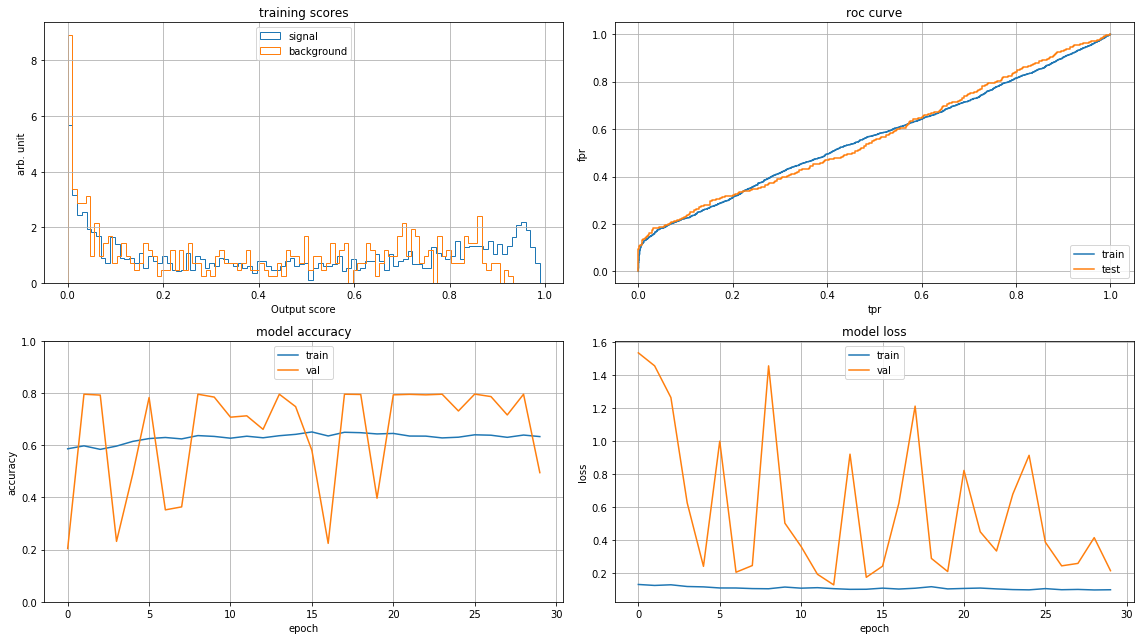

> auc for train: 0.5656424284673787
> auc for test:  0.5689312619937209

Done.


In [10]:
print "Training new_vs_old. ({})".format("emu")
# get data
print "Loading signal."
xs_emu_new = modify_array(xs_dict_new['500GeV'], weight_id = -1, select_channel = True, channel_id = -4,
                          norm = True, shuffle = True, shuffle_seed = int(time.time()))
xs_emu_old = modify_array(xs_dict_old['500GeV'], weight_id = -1, select_channel = True, channel_id = -4,
                          norm = True, shuffle = True, shuffle_seed = int(time.time()))
# set model and train
model_deep = model.model_0913("new_vs_old", len(selected_features_emu))
model_deep.compile()
model_deep.prepare_array(xs_emu_new, xs_emu_old, selected_features_emu)
model_deep.train(epochs = 30, verbose = 1)
# performance plots
model_deep.show_performance()
print "\nDone."

print "Training old_vs_new.".format("emu")
# set model and train
model_deep = model.model_0913("olg_vs_new", len(selected_features_emu))
model_deep.compile()
model_deep.prepare_array(xs_emu_old, xs_emu_new, selected_features_emu)
model_deep.train(epochs = 30, verbose = 1)
# performance plots
model_deep.show_performance()
print "\nDone."

### B) 2000 GeV

Training new_vs_old. (emu)
Loading signal.
Training array prepared.
> signal shape: (2720, 12)
> background shape: (9945, 12)
Training start. Using model: new_vs_old_2000
Model info: Sequential model optimized with old ntuple at Sep. 9th 2019
Train on 7599 samples, validate on 2533 samples
Epoch 1/30
7599/7599 [==============================] - 3s 413us/step - loss: 0.1216 - acc: 0.5065 - val_loss: 0.2534 - val_acc: 0.7398
Epoch 2/30
7599/7599 [==============================] - 1s 124us/step - loss: 0.1161 - acc: 0.5138 - val_loss: 0.2093 - val_acc: 0.2866
Epoch 3/30
7599/7599 [==============================] - 1s 107us/step - loss: 0.1115 - acc: 0.5216 - val_loss: 0.1324 - val_acc: 0.2985
Epoch 4/30
7599/7599 [==============================] - 1s 105us/step - loss: 0.1100 - acc: 0.5423 - val_loss: 0.1327 - val_acc: 0.6325
Epoch 5/30
7599/7599 [==============================] - 1s 103us/step - loss: 0.1065 - acc: 0.5636 - val_loss: 0.1504 - val_acc: 0.6731
Epoch 6/30
7599/7599 [=======

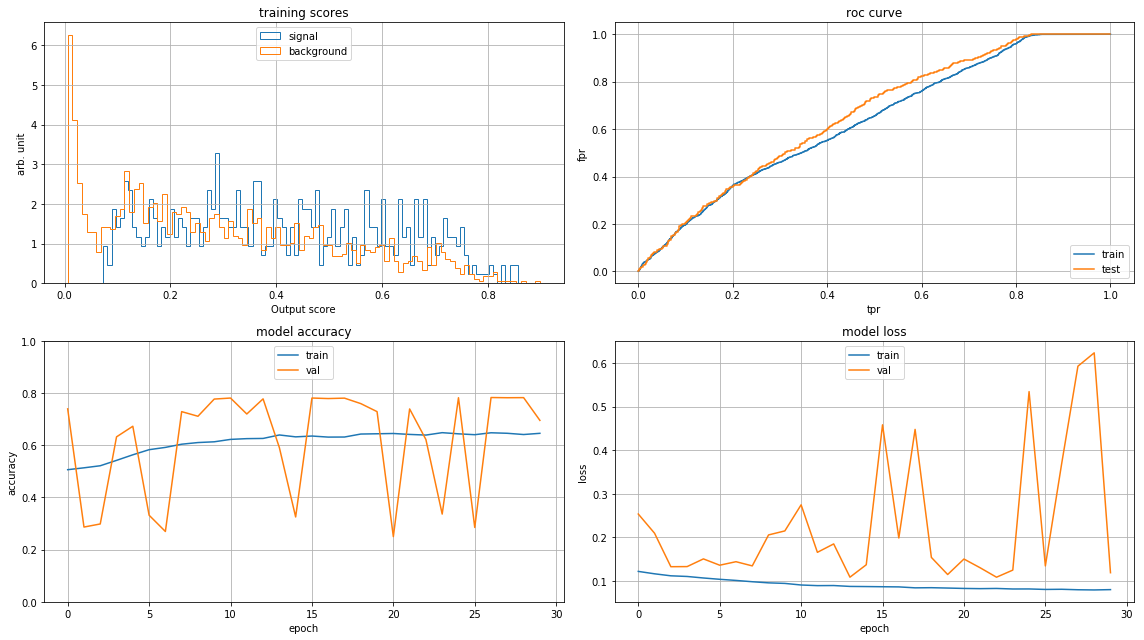

> auc for train: 0.6326226345081774
> auc for test:  0.6577148581906367

Done.
Training old_vs_new.
Training array prepared.
> signal shape: (9945, 12)
> background shape: (2720, 12)
Training start. Using model: olg_vs_new_2000
Model info: Sequential model optimized with old ntuple at Sep. 9th 2019
Train on 7599 samples, validate on 2533 samples
Epoch 1/30
7599/7599 [==============================] - 3s 389us/step - loss: 0.1225 - acc: 0.5211 - val_loss: 0.1555 - val_acc: 0.4437
Epoch 2/30
7599/7599 [==============================] - 1s 105us/step - loss: 0.1163 - acc: 0.5244 - val_loss: 0.2388 - val_acc: 0.2689
Epoch 3/30
7599/7599 [==============================] - 1s 105us/step - loss: 0.1109 - acc: 0.5456 - val_loss: 0.1433 - val_acc: 0.4023
Epoch 4/30
7599/7599 [==============================] - 1s 106us/step - loss: 0.1095 - acc: 0.5565 - val_loss: 0.1965 - val_acc: 0.2957
Epoch 5/30
7599/7599 [==============================] - 1s 105us/step - loss: 0.1067 - acc: 0.5626 - val_los

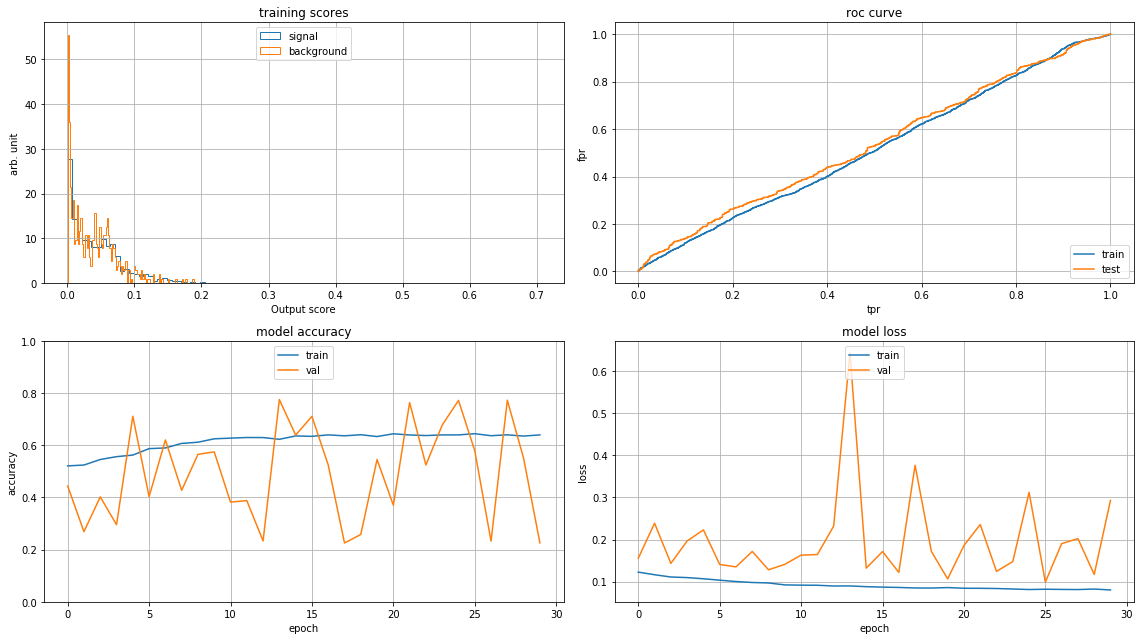

> auc for train: 0.5172808789333984
> auc for test:  0.5358552923431816

Done.


In [11]:
print "Training new_vs_old. ({})".format("emu")
# get data
print "Loading signal."
xs_emu_new = modify_array(xs_dict_new['2000GeV'], weight_id = -1, select_channel = True, channel_id = -4,
                          norm = True, shuffle = True, shuffle_seed = int(time.time()))
xs_emu_old = modify_array(xs_dict_old['2000GeV'], weight_id = -1, select_channel = True, channel_id = -4,
                          norm = True, shuffle = True, shuffle_seed = int(time.time()))
# set model and train
model_deep = model.model_0913("new_vs_old_2000", len(selected_features_emu))
model_deep.compile()
model_deep.prepare_array(xs_emu_new, xs_emu_old, selected_features_emu)
model_deep.train(epochs = 30, verbose = 1)
# performance plots
model_deep.show_performance()
print "\nDone."

print "Training old_vs_new.".format("emu")
# set model and train
model_deep = model.model_0913("olg_vs_new_2000", len(selected_features_emu))
model_deep.compile()
model_deep.prepare_array(xs_emu_old, xs_emu_new, selected_features_emu)
model_deep.train(epochs = 30, verbose = 1)
# performance plots
model_deep.show_performance()
print "\nDone."

## 4 Plot auc vs mass (with full mass train & 3-point mass train)
### A) Use model_total_norm (full mass train)
use mass +- 50GeV bin 

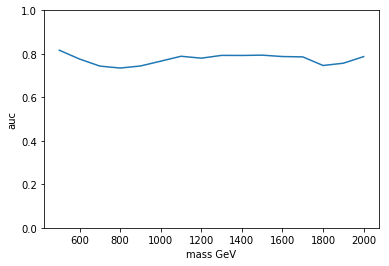

In [44]:
model_used = model_total_norm

xs_emu = modify_array(xs_dict_old['all'], weight_id = -1, select_channel = True, channel_id = -4,
                      select_mass = True, mass_id = 0, mass_min = mass_min, mass_max = mass_max)
xb_emu = modify_array(xb_dict_old['all'], weight_id = -1, select_channel = True, channel_id = -4,
                      select_mass = True, mass_id = 0, mass_min = mass_min, mass_max = mass_max)
xs_emu_selected = get_part_feature(xs_emu, selected_features_emu)
xb_emu_selected = get_part_feature(xb_emu, selected_features_emu)
mass_list = []
auc_list = []
for i in range(0, 16):
    mass = i * 100 + 500
    mass_min = mass - 50
    mass_max = mass + 50
    xs_emu = modify_array(xs_dict_old['all'], weight_id = -1, select_channel = True, channel_id = -4,
                          select_mass = True, mass_id = 0, mass_min = mass_min, mass_max = mass_max)
    xb_emu = modify_array(xb_dict_old['all'], weight_id = -1, select_channel = True, channel_id = -4,
                          select_mass = True, mass_id = 0, mass_min = mass_min, mass_max = mass_max)
    xs_emu_selected = get_part_feature(xs_emu, selected_features_emu)
    xb_emu_selected = get_part_feature(xb_emu, selected_features_emu)
    ys_emu = np.ones(len(xs_emu_selected))
    yb_emu = np.zeros(len(xb_emu_selected))
    x_emu = np.concatenate((xs_emu_selected, xb_emu_selected))
    y_emu = np.concatenate((ys_emu, yb_emu))
    predicti_y = model_used.get_model().predict(x_emu)
    fpr, tpr, threshold = roc_curve(y_emu, predicti_y)
    auc_value = auc(fpr, tpr)
    mass_list.append(mass)
    auc_list.append(auc_value)
plt.plot(mass_list, auc_list)
plt.ylim((0, 1))
plt.xlabel("mass GeV")
plt.ylabel("auc")
plt.show()

### B) Use model_3_point_norm (3-point mass train)
use mass +- 50GeV bin 

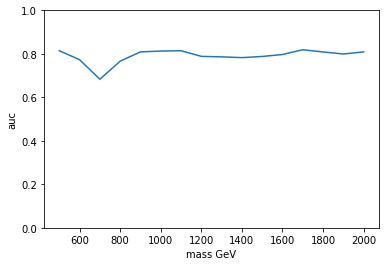

In [20]:
model_used = model_3_point_norm

mass_list = []
auc_list = []
for i in range(0, 16):
    mass = i * 100 + 500
    mass_min = mass - 50
    mass_max = mass + 50
    xs_emu = modify_array(xs_dict_old['all'], weight_id = -1, select_channel = True, channel_id = -4,
                          select_mass = True, mass_id = 0, mass_min = mass_min, mass_max = mass_max)
    xb_emu = modify_array(xb_dict_old['all'], weight_id = -1, select_channel = True, channel_id = -4,
                          select_mass = True, mass_id = 0, mass_min = mass_min, mass_max = mass_max)
    xs_emu_selected = get_part_feature(xs_emu, selected_features_emu)
    xb_emu_selected = get_part_feature(xb_emu, selected_features_emu)
    ys_emu = np.ones(len(xs_emu_selected))
    yb_emu = np.zeros(len(xb_emu_selected))
    x_emu = np.concatenate((xs_emu_selected, xb_emu_selected))
    y_emu = np.concatenate((ys_emu, yb_emu))
    predicti_y = model_used.get_model().predict(x_emu)
    fpr, tpr, threshold = roc_curve(y_emu, predicti_y)
    auc_value = auc(fpr, tpr)
    mass_list.append(mass)
    auc_list.append(auc_value)
plt.plot(mass_list, auc_list)
plt.ylim((0, 1))
plt.xlabel("mass GeV")
plt.ylabel("auc")
plt.show()

### B) Use model_4_point_norm (4-point mass train)
use mass +- 50GeV bin 

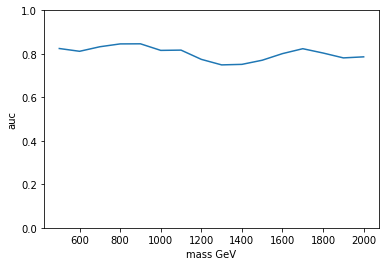

In [21]:
model_used = model_4_point_norm

mass_list = []
auc_list = []
for i in range(0, 16):
    mass = i * 100 + 500
    mass_min = mass - 50
    mass_max = mass + 50
    xs_emu = modify_array(xs_dict_old['all'], weight_id = -1, select_channel = True, channel_id = -4,
                          select_mass = True, mass_id = 0, mass_min = mass_min, mass_max = mass_max)
    xb_emu = modify_array(xb_dict_old['all'], weight_id = -1, select_channel = True, channel_id = -4,
                          select_mass = True, mass_id = 0, mass_min = mass_min, mass_max = mass_max)
    xs_emu_selected = get_part_feature(xs_emu, selected_features_emu)
    xb_emu_selected = get_part_feature(xb_emu, selected_features_emu)
    ys_emu = np.ones(len(xs_emu_selected))
    yb_emu = np.zeros(len(xb_emu_selected))
    x_emu = np.concatenate((xs_emu_selected, xb_emu_selected))
    y_emu = np.concatenate((ys_emu, yb_emu))
    predicti_y = model_used.get_model().predict(x_emu)
    fpr, tpr, threshold = roc_curve(y_emu, predicti_y)
    auc_value = auc(fpr, tpr)
    mass_list.append(mass)
    auc_list.append(auc_value)
plt.plot(mass_list, auc_list)
plt.ylim((0, 1))
plt.xlabel("mass GeV")
plt.ylabel("auc")
plt.show()

# test area

In [ ]:
test_dict = {}
a = 1
b = 2
test_dict['a'] = a
test_dict['b'] = b
print test_dict

a = 10
b = 20
print test_dict

test_dict['a'] = 100
print test_dict
print a

In [ ]:
from lfv_pdnn_code_v1.common import print_helper

print_helper.print_warning("test  warning")

In [18]:
test_list = ["a", 'b', 'c']
print 'a' in test_list

True


In [1]:
import datetime

print datetime.date.today().strftime("_%m_%d_%Y")

_10_01_2019


In [20]:
import os
test_path = "/mnt/asdfasfas"
print os.path.split(test_path)[0]

/mnt
